In [22]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

#sklearn
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler
from sklearn.preprocessing import KBinsDiscretizer

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, precision_score, recall_score, make_scorer
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer

from sklearn.neighbors import KNeighborsClassifier

#json
import json

<h3>Functions</h3>

In [23]:
def plot_grid_search_results(grid_results, grid_best_params, grid_best_score):
    
    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (12,18)) #figsize = (13,30)
    
    ax1.errorbar(x = grid_results['param_n_neighbors'].data, 
                 y = grid_results['mean_test_f1'],
                 color = '#B8002E',
                 yerr = grid_results['std_test_f1'],
                 ecolor = 'orange')
    ax1.set_xlabel('n_neigbors')
    ax1.set_ylabel('f1')
    ax1.set_title('Classification F1')
    
    ax2.errorbar(x = grid_results['param_n_neighbors'].data, 
                 y = grid_results['mean_test_recall'],
                 color = '#B8002E',
                 yerr = grid_results['std_test_recall'],
                 ecolor = 'orange')
    ax2.set_xlabel('n_neigbors') 
    ax2.set_ylabel('recall')
    ax2.set_title('Classification Recall')
    
    ax3.errorbar(x = grid_results['param_n_neighbors'].data, 
                 y = grid_results['mean_test_roc_auc'],
                 color = '#B8002E',
                 yerr = grid_results['std_test_roc_auc'],
                 ecolor = 'orange')
    ax3.plot([grid_best_params['n_neighbors']], [grid_best_score], 
              marker='.', 
              markeredgewidth=3,
              c='r')
    ax3.annotate('best k', xy = (grid_best_params['n_neighbors'], grid_best_score),
                 xytext = (grid_best_params['n_neighbors'] + 1, grid_best_score + 0.02),
                 arrowprops=dict(facecolor='black', shrink=0.01))
    ax3.set_xlabel('n_neigbors') 
    ax3.set_ylabel('roc auc')
    ax3.set_title('Classification Roc Auc')

    fig.tight_layout()
    plt.show()

In [24]:
def results_permutation_importance(res, attr):
    
    # get importance
    importance = res.importances_mean
    
    # summarize feature importance
    feature_importances = []
    for col, imp in zip(attr, importance):
        feature_importances.append((col, imp))
  
    sorted_feature_importances = sorted(feature_importances, key=lambda tup:(-tup[1], tup[0]))
    
    return sorted_feature_importances

In [25]:
def plot_permutation_importance(res, attr, tit):
    
    fig, ax = plt.subplots(figsize = (12,8)) 
    
    feature_names = np.r_[attr]
    
    importance = res.importances_mean
    sorted_idx = res.importances_mean.argsort()
    
    y_ticks = np.arange(0, len(feature_names))
    ax.barh(y_ticks, importance[sorted_idx], height=0.7, color = "#CC6600")
    ax.set_yticklabels(feature_names[sorted_idx])
    ax.set_yticks(y_ticks)
    ax.set_title(tit)
    
    fig.tight_layout()
    plt.show()

In [26]:
def draw_confusion_matrix(Clf, X, y):
    
    titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
    
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(Clf, X, y,
                                 cmap='OrRd',
                                 normalize=normalize)
        disp.ax_.set_title(title)
    
    plt.show()

In [27]:
def draw_roc_curve(Y_test, Y_pred, diz, k):
    
    fig, ax = plt.subplots() #figsize = (13,30)
    
    fpr, tpr, _ = roc_curve(Y_test, Y_pred)
    roc_auc = roc_auc_score(Y_test, Y_pred, average = None)
    
    diz[k] = {"fpr": fpr.tolist(), "tpr": tpr.tolist(), "roc": roc_auc}
    
    ax.plot(fpr, tpr, color = "#994D00", label='ROC curve (area = %0.2f)' % (roc_auc))
    ax.plot([0, 1], [0, 1], 'r--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate') 
    ax.set_title('Roc curve of the model')
    ax.tick_params(axis='both')
    ax.legend(loc="lower right", fontsize=14, frameon=False)
    
    fig.tight_layout()
    plt.show()

<h3>Numerical encoding</h3>

In [28]:
df = pd.read_csv("Numerical_Encoding_Train_HR_Employee_Attrition.csv")

In [29]:
df

,Age,Attrition,BusinessTravel,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
0,52,0,2,9,4,2,0,3,3,11,...,17,3,0,2,2,8,7,156.613636,0.387172,2.6
1,36,0,2,1,1,2,0,3,5,8,...,14,3,1,3,3,1,8,157.942308,0.411421,2.8
2,25,0,3,16,3,3,0,3,2,5,...,25,3,1,4,3,1,5,448.055556,0.704402,3.2
3,33,0,2,5,4,2,0,3,1,4,...,14,2,0,1,3,3,7,271.907692,0.841632,2.4
4,31,0,2,9,2,3,1,3,1,3,...,12,3,0,2,3,10,2,106.373333,0.207947,3.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,38,1,2,12,3,3,1,4,1,2,...,15,4,0,2,3,10,0,282.466667,0.789828,3.2
879,37,0,2,16,2,4,1,4,1,3,...,13,2,2,3,2,17,0,76.291667,0.711223,3.2
880,33,1,1,6,4,2,1,1,2,5,...,18,2,0,2,2,11,7,272.881579,0.751820,2.0
881,33,0,2,4,1,3,0,2,2,5,...,12,1,0,2,4,3,2,208.666667,0.862289,2.2


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883 entries, 0 to 882
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       883 non-null    int64  
 1   Attrition                 883 non-null    int64  
 2   BusinessTravel            883 non-null    int64  
 3   DistanceFromHome          883 non-null    int64  
 4   Education                 883 non-null    int64  
 5   EnvironmentSatisfaction   883 non-null    int64  
 6   Gender                    883 non-null    int64  
 7   JobInvolvement            883 non-null    int64  
 8   JobLevel                  883 non-null    int64  
 9   JobRole                   883 non-null    int64  
 10  JobSatisfaction           883 non-null    int64  
 11  MonthlyIncome             883 non-null    int64  
 12  NumCompaniesWorked        883 non-null    int64  
 13  OverTime                  883 non-null    int64  
 14  PercentSal

In [31]:
df.describe()

,Age,Attrition,BusinessTravel,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
count,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,...,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000
mean,36.554926,0.173273,2.062288,9.201586,2.886750,2.684032,0.388448,2.750849,1.919592,4.371461,...,15.207248,2.716874,0.793884,2.665912,2.767837,6.326161,3.919592,234.245826,0.463811,2.724575
std,8.266129,0.378698,0.512402,8.241818,1.008285,1.092567,0.487674,0.729354,1.007506,2.290214,...,3.589332,1.078137,0.865362,1.187828,0.721713,4.523567,3.435392,130.196628,0.320030,0.438169
min,18.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,26.043478,0.000000,1.200000
25%,30.000000,0.000000,2.000000,2.000000,2.000000,2.000000,0.000000,2.000000,1.000000,3.000000,...,12.000000,2.000000,0.000000,2.000000,2.000000,3.000000,2.000000,130.630208,0.129730,2.400000
50%,35.000000,0.000000,2.000000,7.000000,3.000000,3.000000,0.000000,3.000000,2.000000,4.000000,...,14.000000,3.000000,1.000000,2.000000,3.000000,5.000000,3.000000,212.279070,0.528359,2.800000
75%,42.000000,0.000000,2.000000,14.000000,4.000000,4.000000,1.000000,3.000000,2.000000,5.000000,...,18.000000,4.000000,1.000000,3.000000,3.000000,9.000000,7.000000,309.906250,0.762560,3.000000
max,60.000000,1.000000,3.000000,29.000000,5.000000,4.000000,1.000000,4.000000,5.000000,11.000000,...,25.000000,4.000000,3.000000,6.000000,4.000000,20.000000,16.000000,590.976744,0.951396,4.000000


<h3>Discretization with KBinsDiscretizer and Column Transformer</h3>

Continuous features to discretize:
- <b>Age</b>
- <b>DistanceFromHome</b>
- <b>YearsAtCompany</b>
- <b>YearsInCurrentRole</b>
- <b>NumCompaniesWorked</b>
- <b>MonthlyIncome</b>
- <b>MonthlyHours</b>
- <b>PercentSalaryHike</b>

In [32]:
columns_to_discretize = ['Age','DistanceFromHome','YearsAtCompany','YearsInCurrentRole',
'NumCompaniesWorked','MonthlyIncome','MonthlyHours','PercentSalaryHike']

In [33]:
ct = ColumnTransformer([('k_means_discretizer', 
                         KBinsDiscretizer(n_bins = 4, encode = 'ordinal', strategy = 'kmeans'),
                        ['Age','DistanceFromHome','YearsAtCompany','YearsInCurrentRole',
                        'NumCompaniesWorked','MonthlyIncome','MonthlyHours','PercentSalaryHike'])], 
                       remainder = "drop")

In [34]:
df.head()

,Age,Attrition,BusinessTravel,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
0,52,0,2,9,4,2,0,3,3,11,...,17,3,0,2,2,8,7,156.613636,0.387172,2.6
1,36,0,2,1,1,2,0,3,5,8,...,14,3,1,3,3,1,8,157.942308,0.411421,2.8
2,25,0,3,16,3,3,0,3,2,5,...,25,3,1,4,3,1,5,448.055556,0.704402,3.2
3,33,0,2,5,4,2,0,3,1,4,...,14,2,0,1,3,3,7,271.907692,0.841632,2.4
4,31,0,2,9,2,3,1,3,1,3,...,12,3,0,2,3,10,2,106.373333,0.207947,3.2


In [35]:
df_temp = pd.DataFrame(ct.fit_transform(df), columns = columns_to_discretize)
df_temp.head()

,Age,DistanceFromHome,YearsAtCompany,YearsInCurrentRole,NumCompaniesWorked,MonthlyIncome,MonthlyHours,PercentSalaryHike
0,3.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0
1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,2.0,0.0,1.0,0.0,0.0,3.0,3.0
3,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0
4,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [36]:
df.head()

,Age,Attrition,BusinessTravel,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
0,52,0,2,9,4,2,0,3,3,11,...,17,3,0,2,2,8,7,156.613636,0.387172,2.6
1,36,0,2,1,1,2,0,3,5,8,...,14,3,1,3,3,1,8,157.942308,0.411421,2.8
2,25,0,3,16,3,3,0,3,2,5,...,25,3,1,4,3,1,5,448.055556,0.704402,3.2
3,33,0,2,5,4,2,0,3,1,4,...,14,2,0,1,3,3,7,271.907692,0.841632,2.4
4,31,0,2,9,2,3,1,3,1,3,...,12,3,0,2,3,10,2,106.373333,0.207947,3.2


In [37]:
for column in df_temp:
    if column in df:
        df[column] = df_temp[column]

In [38]:
df.head()

,Age,Attrition,BusinessTravel,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
0,3.0,0,2,1.0,4,2,0,3,3,11,...,1.0,3,0,2,2,1.0,1.0,1.0,0.387172,2.6
1,1.0,0,2,0.0,1,2,0,3,5,8,...,0.0,3,1,3,3,0.0,1.0,1.0,0.411421,2.8
2,0.0,0,3,2.0,3,3,0,3,2,5,...,3.0,3,1,4,3,0.0,1.0,3.0,0.704402,3.2
3,1.0,0,2,0.0,4,2,0,3,1,4,...,0.0,2,0,1,3,0.0,1.0,2.0,0.841632,2.4
4,1.0,0,2,1.0,2,3,1,3,1,3,...,0.0,3,0,2,3,1.0,0.0,0.0,0.207947,3.2


<h3>Divide into features and target</h3>

In [39]:
attributes = [col for col in df.columns if col != 'Attrition']

X = df[attributes].values
y = df['Attrition']

<h3>Stratified Holdout combined with Stratified K-fold Cross Validation</h3>

In [40]:
scaler_dict = dict()

<h4>MinMaxScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.5689510280306053
Best parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best estimator: KNeighborsClassifier(n_neighbors=3, p=1)

Best k ('n_neighbors'): 3

Plots of the metrics used by the grid search


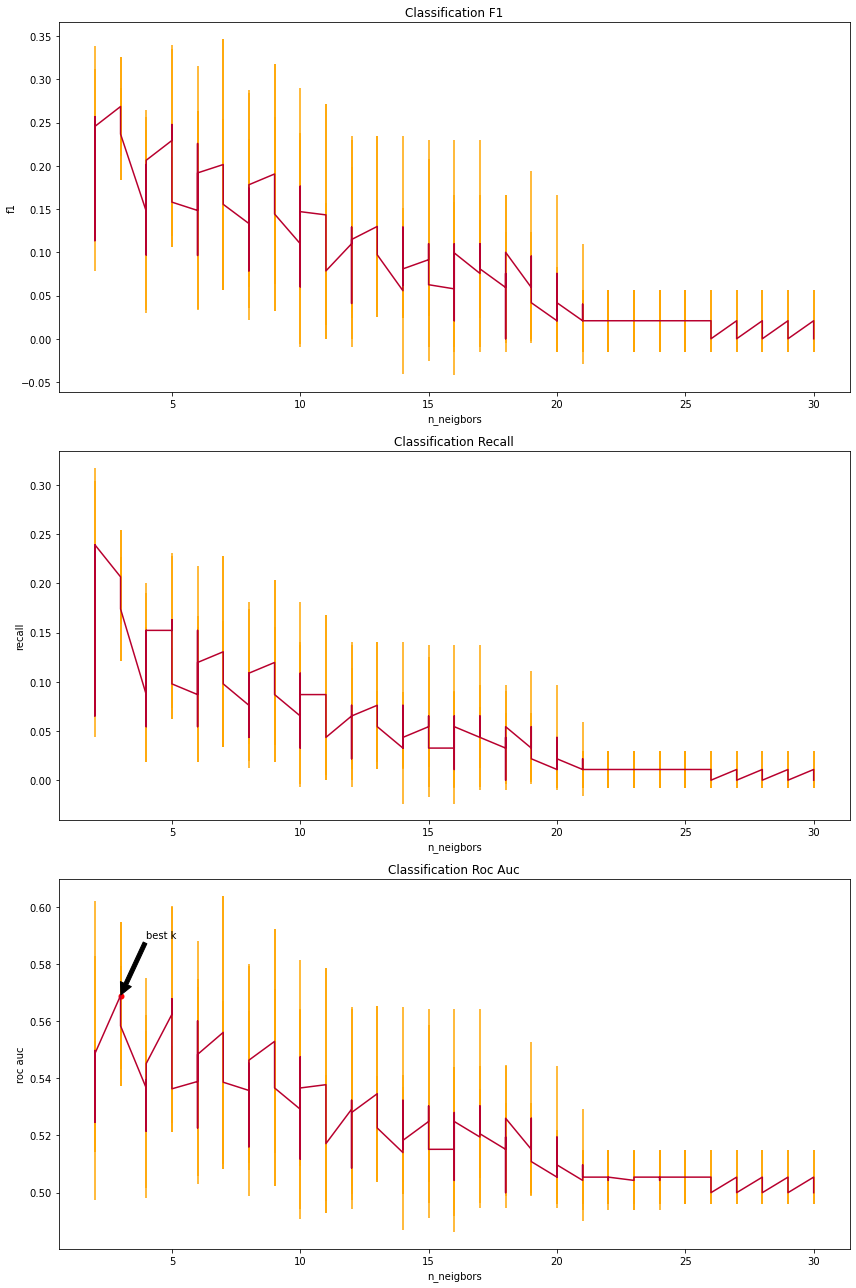



Permutation importances of the training set

StockOptionLevel                                   0.005100
MonthlyHours                                       0.004445
TrainingTimesLastYear                              0.003171
PercentSalaryHike                                  0.002770
OverTime                                           0.002170
BusinessTravel                                     0.001865
TaxRate                                            0.001822
RelationshipSatisfaction                           0.001552
OverallSatisfaction                                0.001461
MonthlyIncome                                      0.000407
JobInvolvement                                     -0.001214
WorkLifeBalance                                    -0.002120
EnvironmentSatisfaction                            -0.002660
JobRole                                            -0.003676
Gender                                             -0.004497
YearsInCurrentRole                              

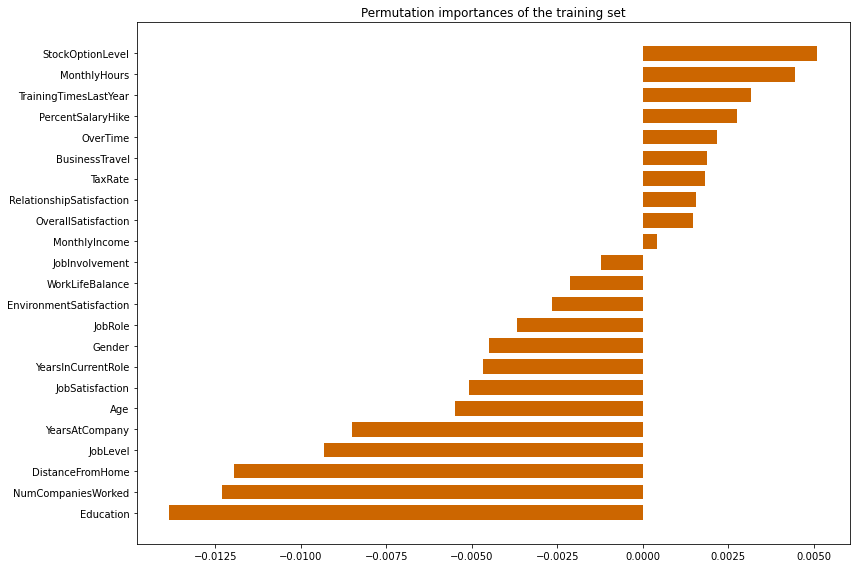



Predictions

Permutation importances of the test set

StockOptionLevel                                   0.032737
NumCompaniesWorked                                 0.032574
YearsAtCompany                                     0.029223
Age                                                0.024022
JobRole                                            0.010384
RelationshipSatisfaction                           0.009990
EnvironmentSatisfaction                            0.006029
JobLevel                                           0.005567
OverTime                                           0.004014
OverallSatisfaction                                0.002985
JobInvolvement                                     0.002507
PercentSalaryHike                                  0.001385
TaxRate                                            -0.000627
BusinessTravel                                     -0.000918
MonthlyHours                                       -0.000979
YearsInCurrentRole                       

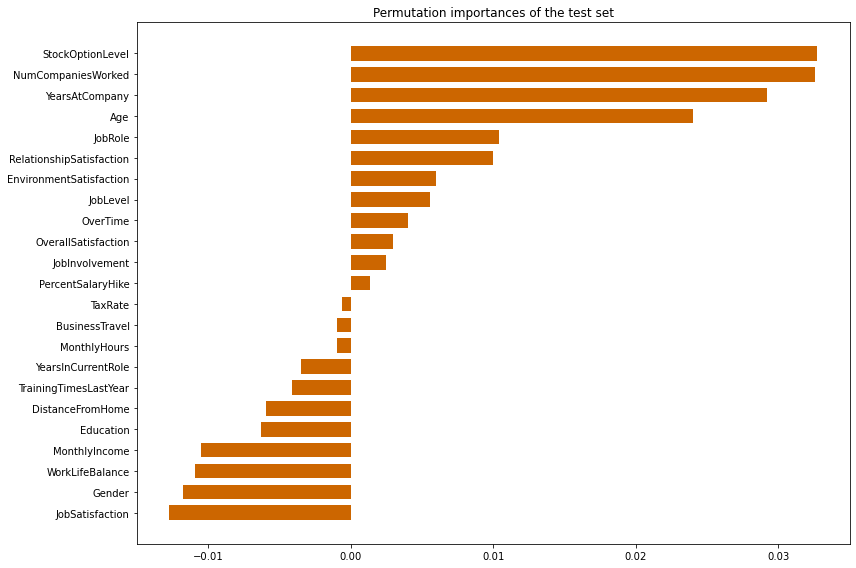



Confusion matrix


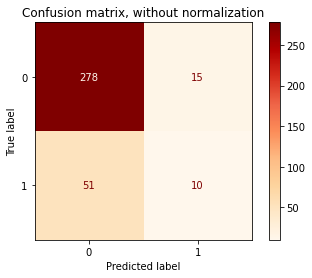

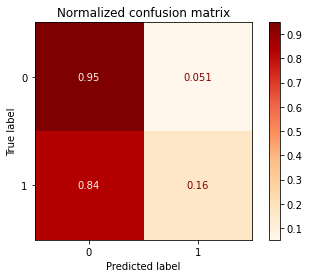


Classification report
              precision    recall  f1-score   support

           0       0.84      0.95      0.89       293
           1       0.40      0.16      0.23        61

    accuracy                           0.81       354
   macro avg       0.62      0.56      0.56       354
weighted avg       0.77      0.81      0.78       354


Metrics

Accuracy 0.8135593220338984
F1-score [0.89389068 0.23255814]
Precision [0.8449848 0.4      ]
Recall [0.94880546 0.16393443]
Roc_auc 0.5563699434901808


Roc curve



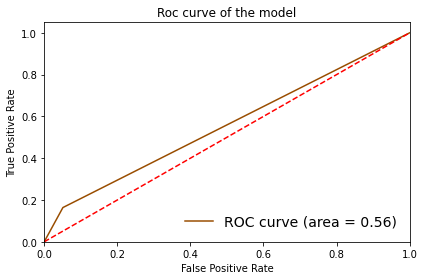


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.5911373771087107
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


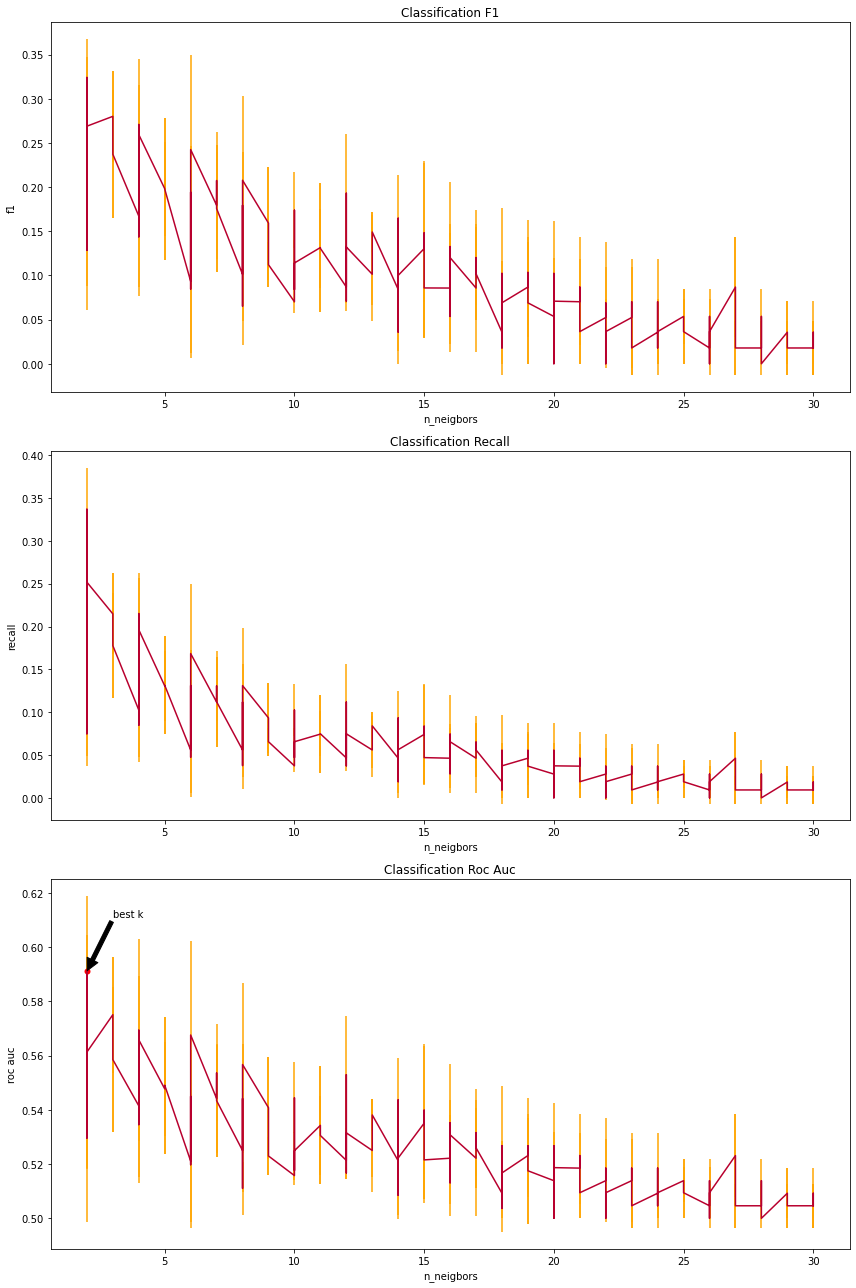



Permutation importances of the training set

Age                                                0.000000
BusinessTravel                                     0.000000
DistanceFromHome                                   0.000000
Education                                          0.000000
EnvironmentSatisfaction                            0.000000
Gender                                             0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole                                            0.000000
JobSatisfaction                                    0.000000
MonthlyHours                                       0.000000
MonthlyIncome                                      0.000000
NumCompaniesWorked                                 0.000000
OverTime                                           0.000000
OverallSatisfaction                                0.000000
PercentSalaryHike                                  0.

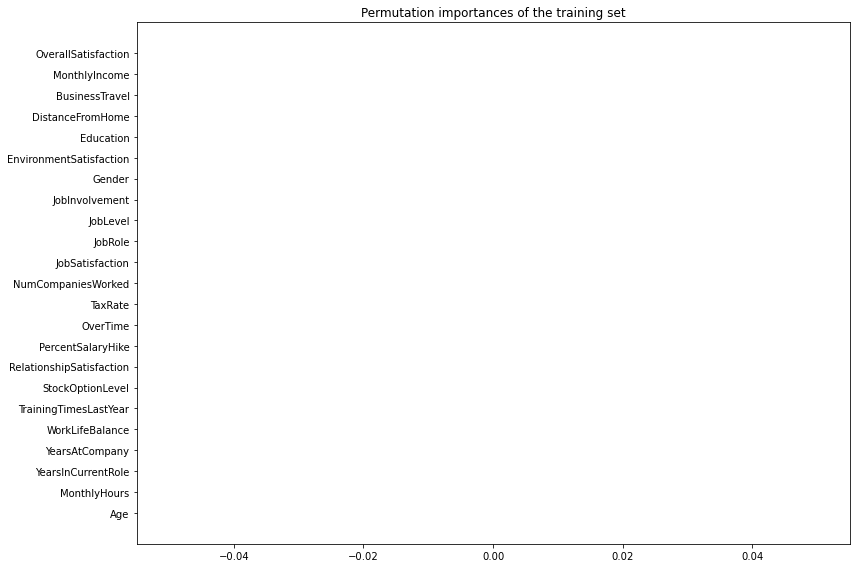



Predictions

Permutation importances of the test set

OverTime                                           0.065078
EnvironmentSatisfaction                            0.009927
JobInvolvement                                     0.009048
YearsInCurrentRole                                 0.006745
TrainingTimesLastYear                              -0.000973
StockOptionLevel                                   -0.002457
JobRole                                            -0.003559
YearsAtCompany                                     -0.004358
PercentSalaryHike                                  -0.005152
BusinessTravel                                     -0.006790
Gender                                             -0.007688
Age                                                -0.008165
Education                                          -0.008850
JobLevel                                           -0.015312
NumCompaniesWorked                                 -0.017381
MonthlyHours                     

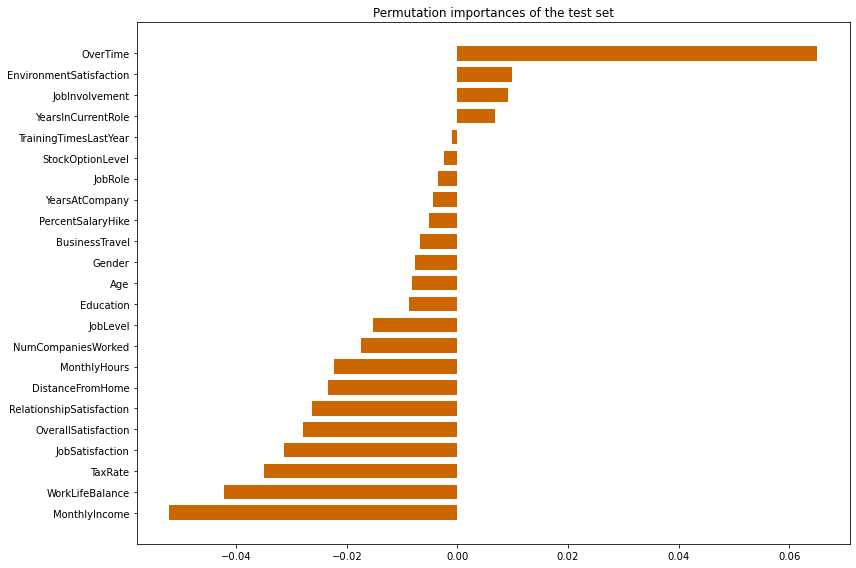



Confusion matrix


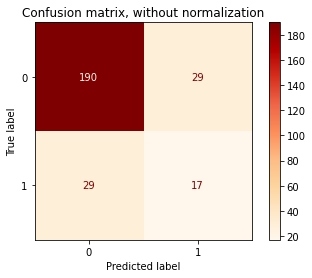

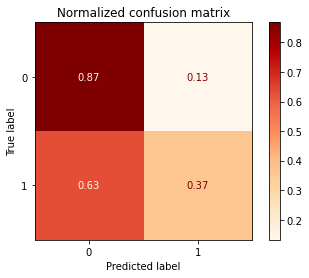


Classification report
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       219
           1       0.37      0.37      0.37        46

    accuracy                           0.78       265
   macro avg       0.62      0.62      0.62       265
weighted avg       0.78      0.78      0.78       265


Metrics

Accuracy 0.7811320754716982
F1-score [0.86757991 0.36956522]
Precision [0.86757991 0.36956522]
Recall [0.86757991 0.36956522]
Roc_auc 0.6185725630335518


Roc curve



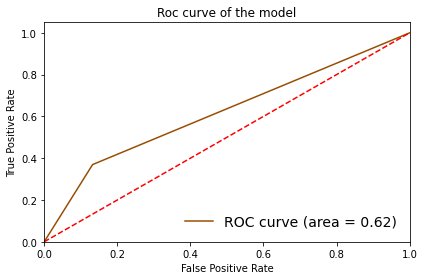


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.6018043894535278
Best parameters: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=4, p=1, weights='distance')

Best k ('n_neighbors'): 4

Plots of the metrics used by the grid search


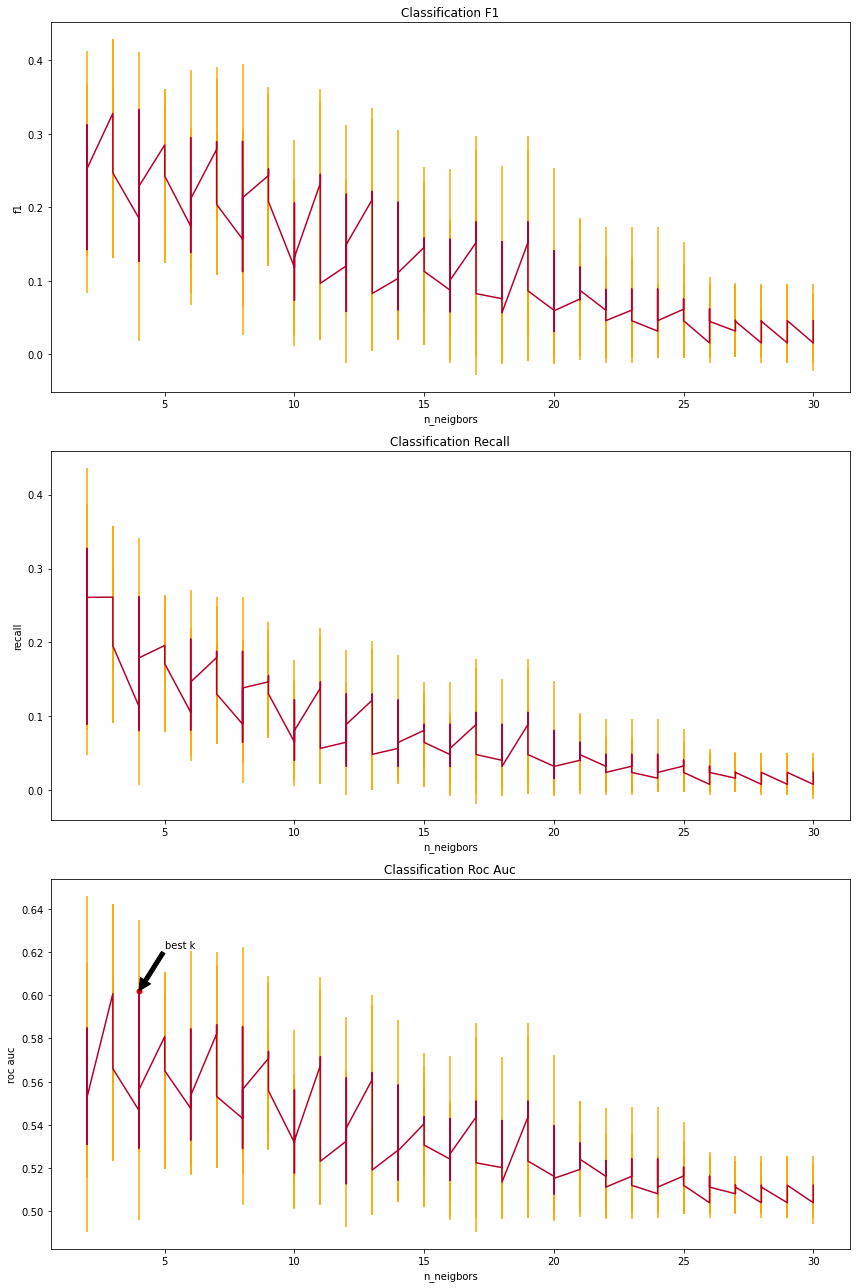



Permutation importances of the training set

OverTime                                           0.000622
Gender                                             0.000087
JobSatisfaction                                    0.000051
MonthlyHours                                       0.000007
EnvironmentSatisfaction                            0.000003
PercentSalaryHike                                  0.000003
RelationshipSatisfaction                           0.000003
JobInvolvement                                     0.000001
YearsAtCompany                                     0.000001
Age                                                0.000000
BusinessTravel                                     0.000000
DistanceFromHome                                   0.000000
Education                                          0.000000
JobLevel                                           0.000000
JobRole                                            0.000000
MonthlyIncome                                      0.

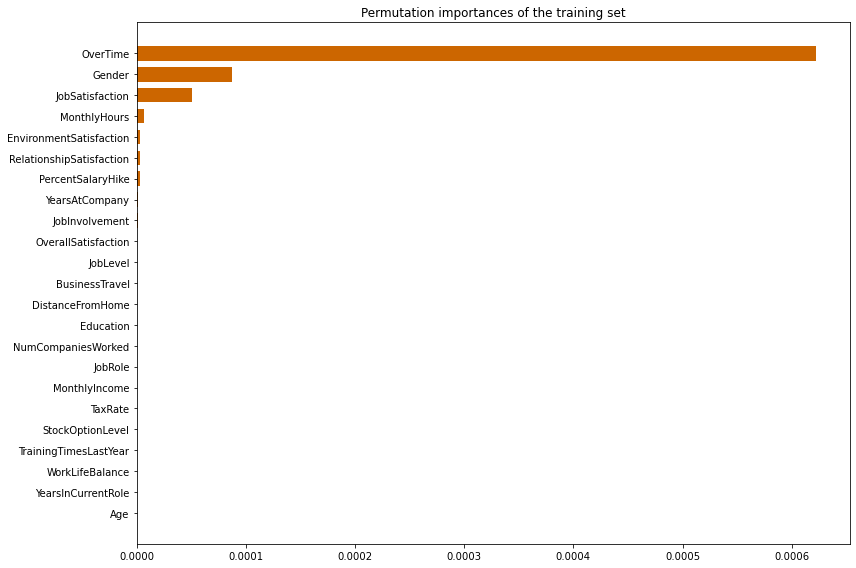



Predictions

Permutation importances of the test set

OverTime                                           0.050199
NumCompaniesWorked                                 0.026977
TaxRate                                            0.021266
MonthlyIncome                                      0.019222
StockOptionLevel                                   0.018847
YearsInCurrentRole                                 0.015698
OverallSatisfaction                                0.010616
JobSatisfaction                                    0.007037
DistanceFromHome                                   0.006319
JobLevel                                           0.002905
PercentSalaryHike                                  0.002784
Age                                                0.002629
BusinessTravel                                     0.001757
JobRole                                            -0.006120
TrainingTimesLastYear                              -0.007181
MonthlyHours                              

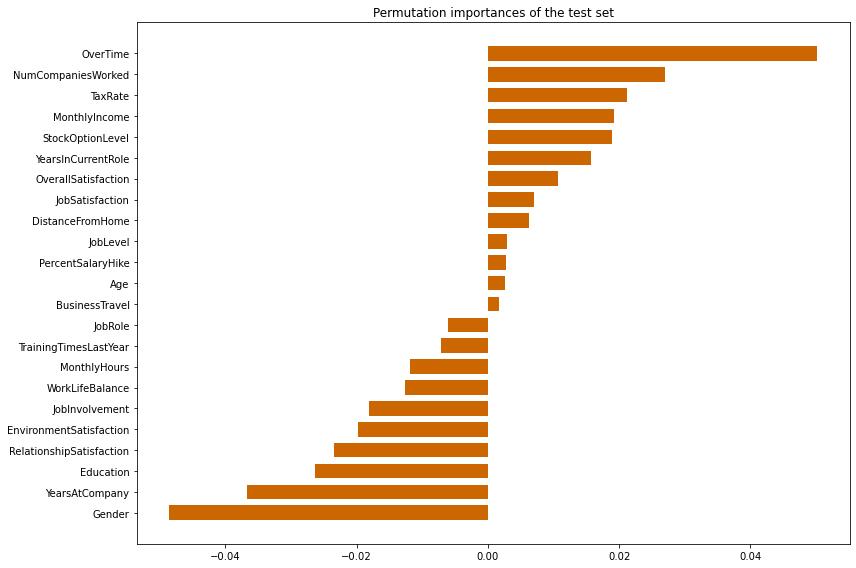



Confusion matrix


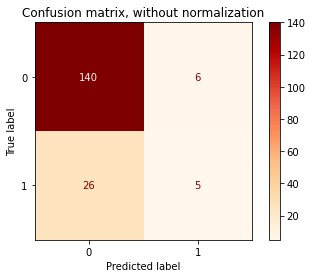

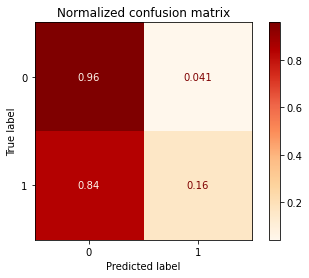


Classification report
              precision    recall  f1-score   support

           0       0.84      0.96      0.90       146
           1       0.45      0.16      0.24        31

    accuracy                           0.82       177
   macro avg       0.65      0.56      0.57       177
weighted avg       0.78      0.82      0.78       177


Metrics

Accuracy 0.8192090395480226
F1-score [0.8974359  0.23809524]
Precision [0.84337349 0.45454545]
Recall [0.95890411 0.16129032]
Roc_auc 0.5600972160848432


Roc curve



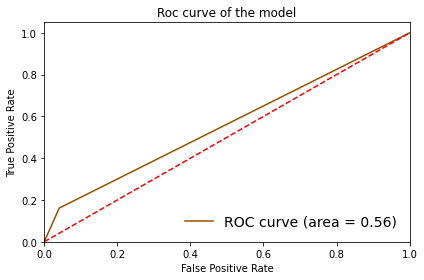


-------------------------------------------------------------------------------------------------------------



In [41]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
min_max_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = MinMaxScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, min_max_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = min_max_dict

<h4>MaxAbsScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.5755199078942597
Best parameters: {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
Best estimator: KNeighborsClassifier(p=1)

Best k ('n_neighbors'): 5

Plots of the metrics used by the grid search


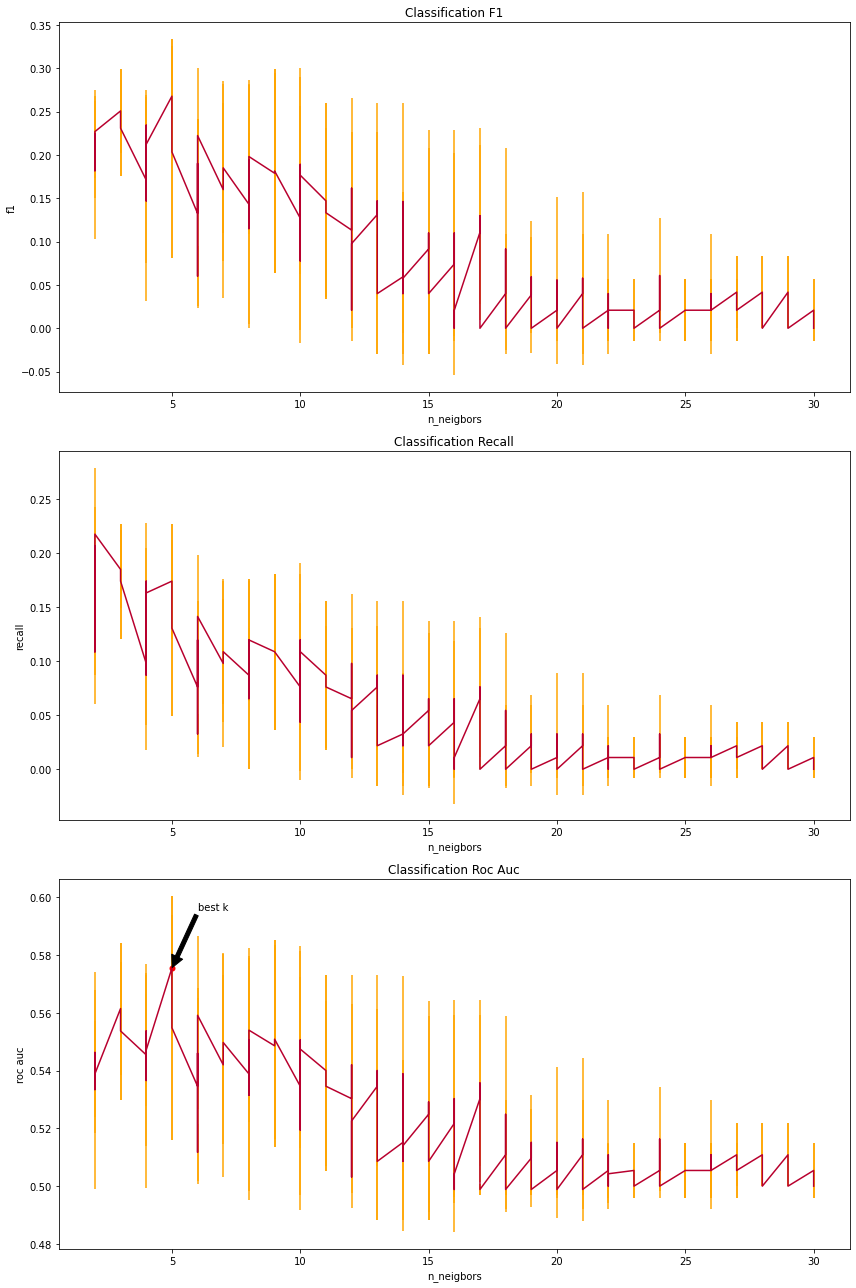



Permutation importances of the training set

OverTime                                           0.013905
YearsInCurrentRole                                 0.007983
MonthlyIncome                                      0.007723
EnvironmentSatisfaction                            0.006639
StockOptionLevel                                   0.006563
PercentSalaryHike                                  0.006090
OverallSatisfaction                                0.005070
RelationshipSatisfaction                           0.002339
TrainingTimesLastYear                              0.001713
TaxRate                                            0.000561
JobLevel                                           -0.000251
JobRole                                            -0.001203
NumCompaniesWorked                                 -0.001214
MonthlyHours                                       -0.001569
JobInvolvement                                     -0.001995
BusinessTravel                                  

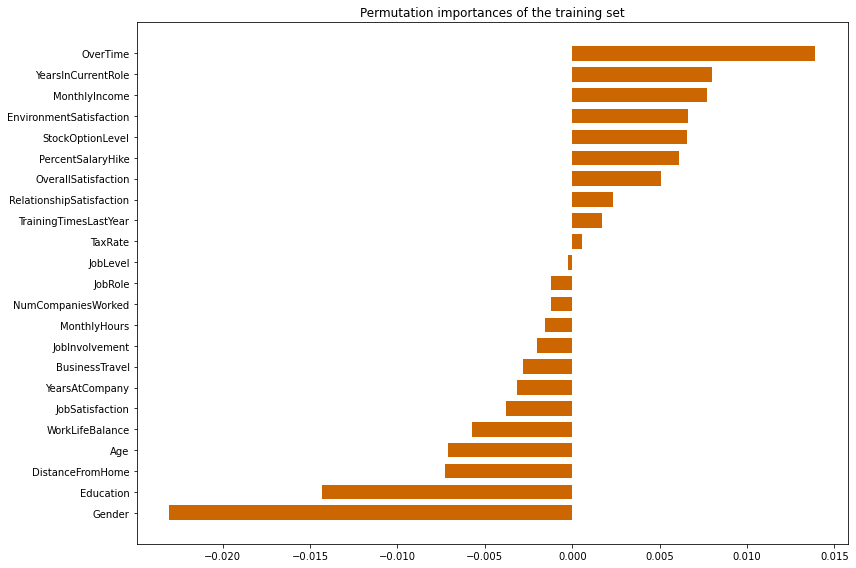



Predictions

Permutation importances of the test set

StockOptionLevel                                   0.043966
OverTime                                           0.042125
PercentSalaryHike                                  0.030868
NumCompaniesWorked                                 0.030745
JobLevel                                           0.023345
EnvironmentSatisfaction                            0.023113
YearsAtCompany                                     0.021560
TaxRate                                            0.020746
JobInvolvement                                     0.018525
RelationshipSatisfaction                           0.017697
OverallSatisfaction                                0.016805
YearsInCurrentRole                                 0.014841
WorkLifeBalance                                    0.014634
JobRole                                            0.013490
Age                                                0.010138
MonthlyIncome                               

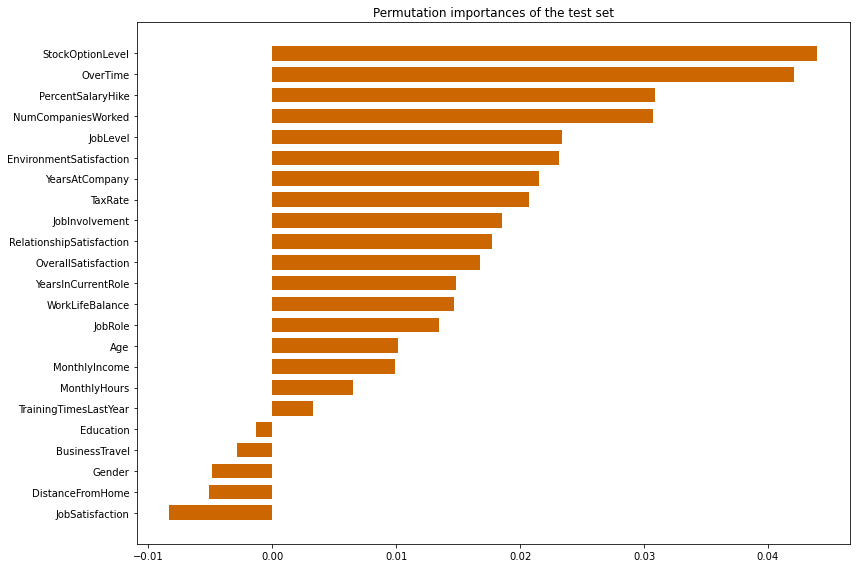



Confusion matrix


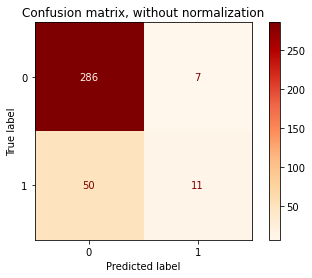

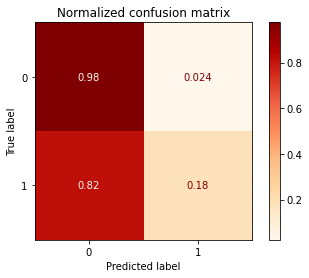


Classification report
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       293
           1       0.61      0.18      0.28        61

    accuracy                           0.84       354
   macro avg       0.73      0.58      0.59       354
weighted avg       0.81      0.84      0.80       354


Metrics

Accuracy 0.8389830508474576
F1-score [0.90937997 0.27848101]
Precision [0.85119048 0.61111111]
Recall [0.97610922 0.18032787]
Roc_auc 0.5782185419347619


Roc curve



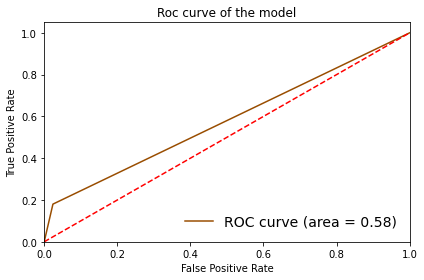


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.5882106251892791
Best parameters: {'n_neighbors': 2, 'p': 2, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


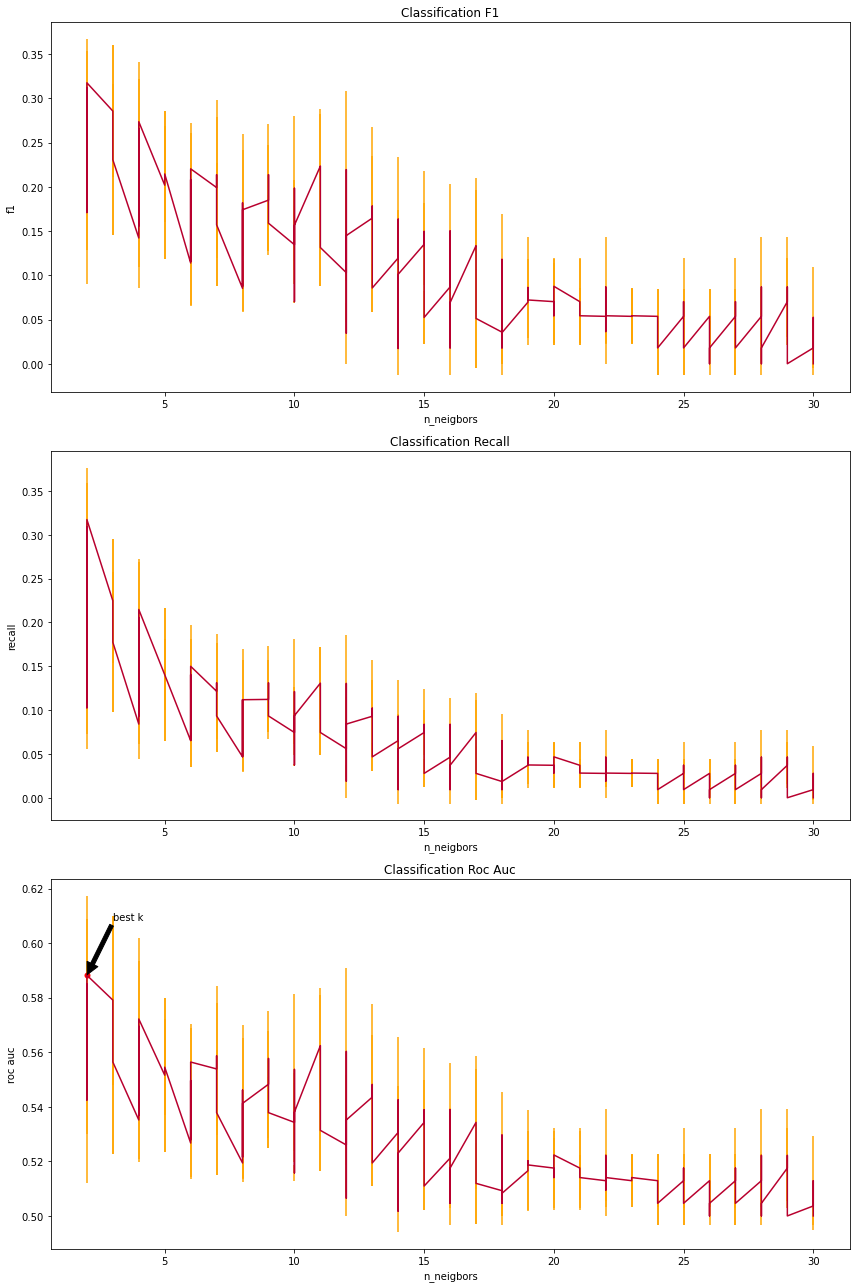



Permutation importances of the training set

OverTime                                           0.061098
Gender                                             0.046441
DistanceFromHome                                   0.007668
NumCompaniesWorked                                 0.007255
YearsAtCompany                                     0.005574
Age                                                0.004922
MonthlyHours                                       0.003450
StockOptionLevel                                   0.001561
PercentSalaryHike                                  0.001219
TaxRate                                            0.000104
JobSatisfaction                                    0.000044
EnvironmentSatisfaction                            0.000026
RelationshipSatisfaction                           0.000013
MonthlyIncome                                      0.000011
BusinessTravel                                     0.000000
Education                                          0.

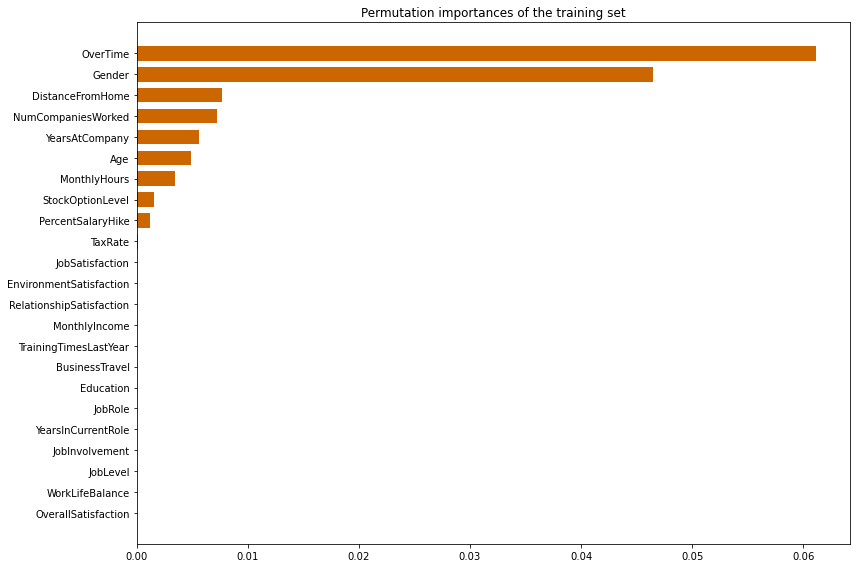



Predictions

Permutation importances of the test set

OverTime                                           0.095459
EnvironmentSatisfaction                            0.028698
MonthlyHours                                       0.028047
StockOptionLevel                                   0.025521
Age                                                0.018975
YearsAtCompany                                     0.015133
BusinessTravel                                     0.015019
Gender                                             0.014274
Education                                          0.014185
NumCompaniesWorked                                 0.013024
PercentSalaryHike                                  0.010879
JobInvolvement                                     0.010770
MonthlyIncome                                      0.010423
JobSatisfaction                                    0.009207
TrainingTimesLastYear                              0.009122
JobRole                                     

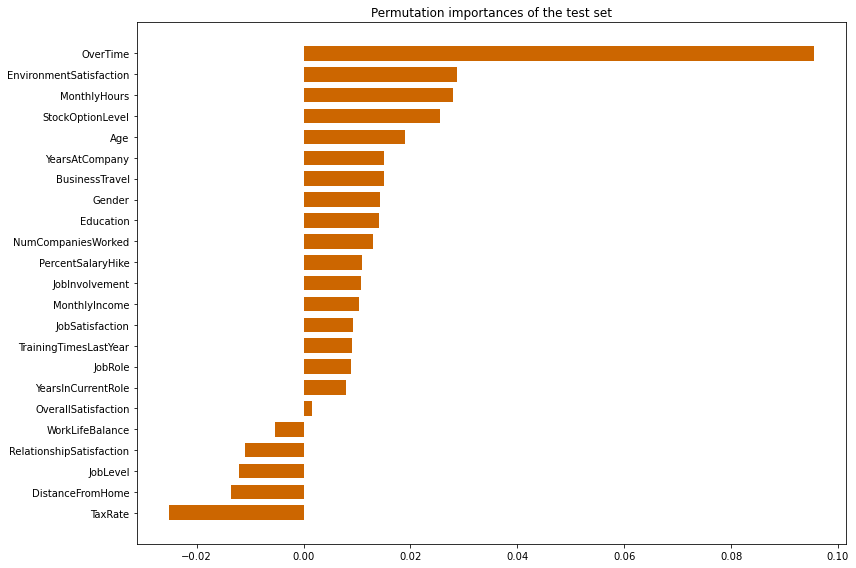



Confusion matrix


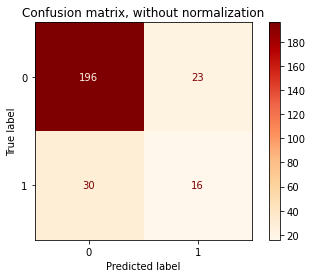

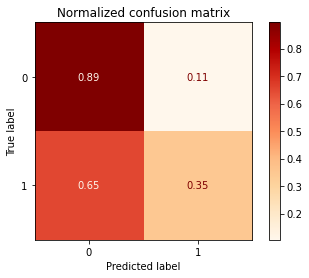


Classification report
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       219
           1       0.41      0.35      0.38        46

    accuracy                           0.80       265
   macro avg       0.64      0.62      0.63       265
weighted avg       0.79      0.80      0.79       265


Metrics

Accuracy 0.8
F1-score [0.88089888 0.37647059]
Precision [0.86725664 0.41025641]
Recall [0.89497717 0.34782609]
Roc_auc 0.6214016279531467


Roc curve



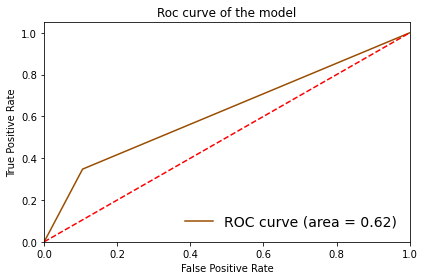


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.6000920606864044
Best parameters: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=4, p=1, weights='distance')

Best k ('n_neighbors'): 4

Plots of the metrics used by the grid search


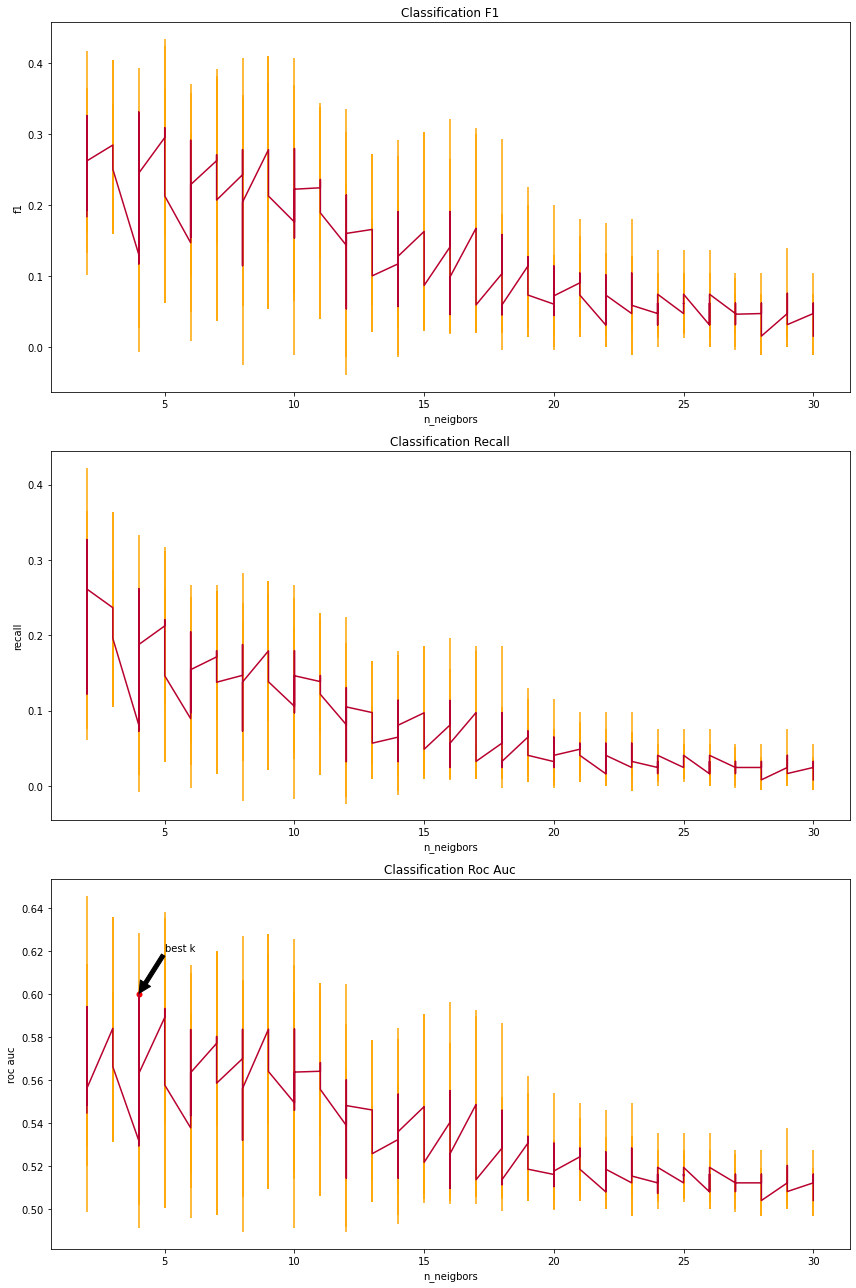



Permutation importances of the training set

OverTime                                           0.001248
Gender                                             0.000066
MonthlyHours                                       0.000045
DistanceFromHome                                   0.000038
NumCompaniesWorked                                 0.000024
Age                                                0.000021
StockOptionLevel                                   0.000018
PercentSalaryHike                                  0.000001
YearsAtCompany                                     0.000001
BusinessTravel                                     0.000000
Education                                          0.000000
EnvironmentSatisfaction                            0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole                                            0.000000
JobSatisfaction                                    0.

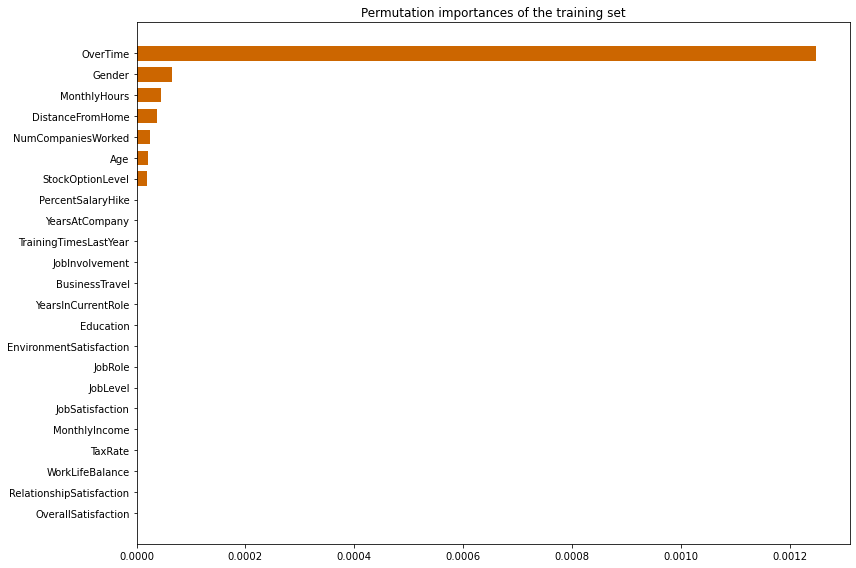



Predictions

Permutation importances of the test set

OverTime                                           0.070283
NumCompaniesWorked                                 0.029408
DistanceFromHome                                   0.026425
OverallSatisfaction                                0.019079
StockOptionLevel                                   0.013544
TaxRate                                            0.005093
YearsInCurrentRole                                 0.004319
TrainingTimesLastYear                              0.002464
JobSatisfaction                                    0.002099
MonthlyIncome                                      0.001215
JobLevel                                           0.000685
JobInvolvement                                     -0.000298
WorkLifeBalance                                    -0.006010
MonthlyHours                                       -0.006518
EnvironmentSatisfaction                            -0.006551
BusinessTravel                          

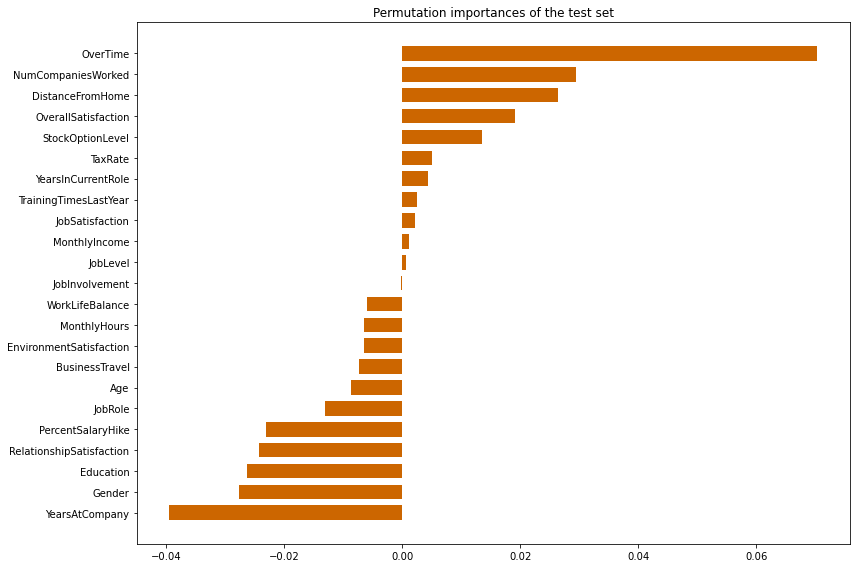



Confusion matrix


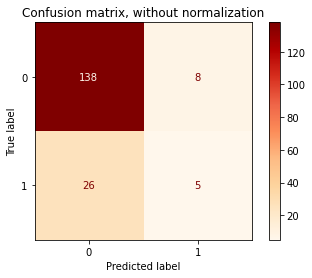

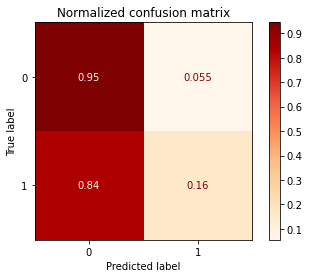


Classification report
              precision    recall  f1-score   support

           0       0.84      0.95      0.89       146
           1       0.38      0.16      0.23        31

    accuracy                           0.81       177
   macro avg       0.61      0.55      0.56       177
weighted avg       0.76      0.81      0.77       177


Metrics

Accuracy 0.807909604519774
F1-score [0.89032258 0.22727273]
Precision [0.84146341 0.38461538]
Recall [0.94520548 0.16129032]
Roc_auc 0.55324790101635


Roc curve



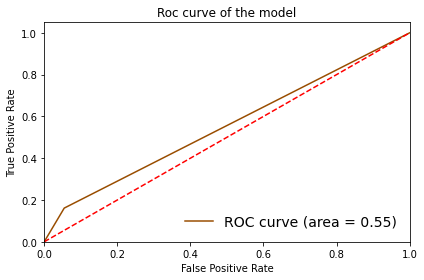


-------------------------------------------------------------------------------------------------------------



In [42]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
max_abs_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = MaxAbsScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, max_abs_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = max_abs_dict

<h4>RobustScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.5938290967110272
Best parameters: {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
Best estimator: KNeighborsClassifier(p=1)

Best k ('n_neighbors'): 5

Plots of the metrics used by the grid search


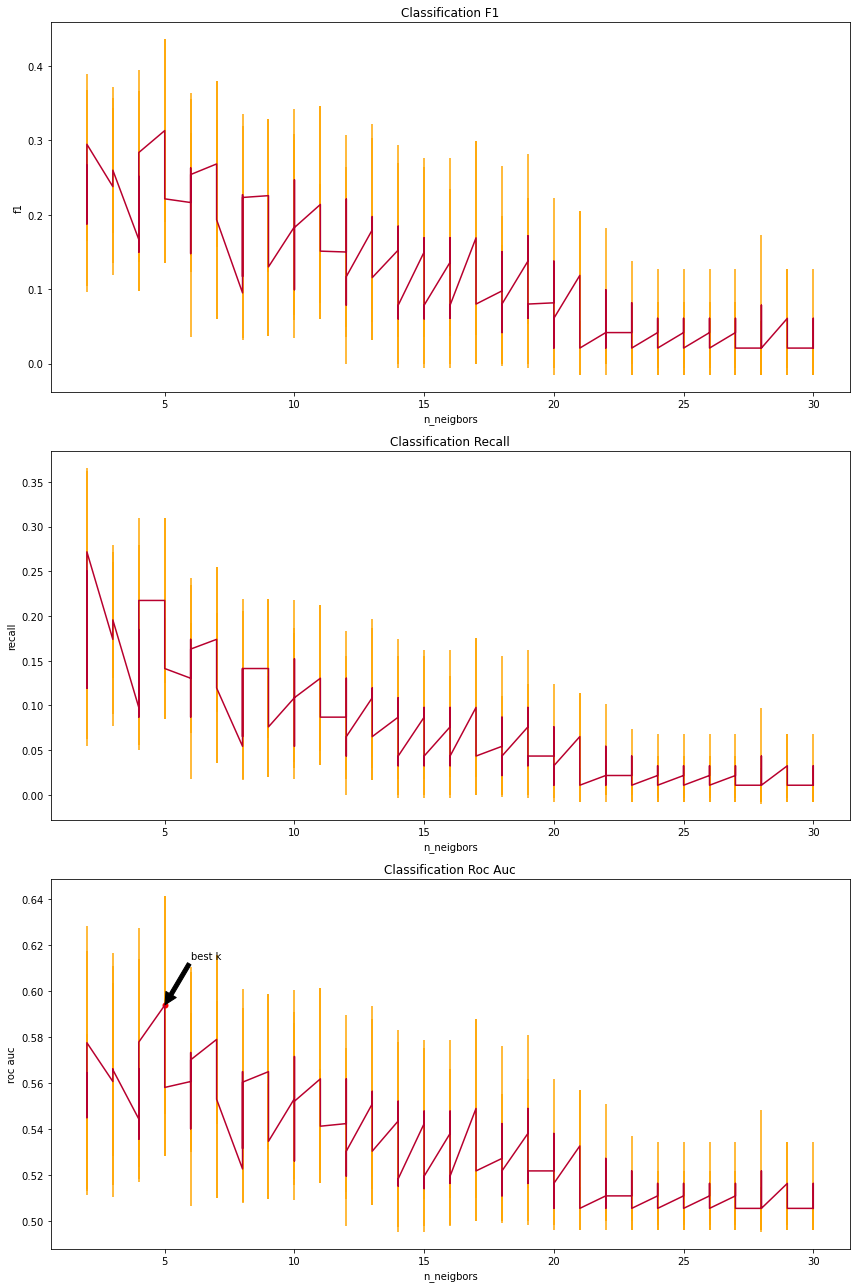



Permutation importances of the training set

YearsInCurrentRole                                 0.012514
MonthlyIncome                                      0.006287
JobRole                                            0.006275
OverTime                                           0.006106
JobSatisfaction                                    0.003881
JobLevel                                           0.003845
YearsAtCompany                                     0.003486
TrainingTimesLastYear                              0.003357
EnvironmentSatisfaction                            0.002153
OverallSatisfaction                                0.001565
PercentSalaryHike                                  0.000879
BusinessTravel                                     0.000846
DistanceFromHome                                   0.000371
Age                                                0.000341
RelationshipSatisfaction                           -0.000701
NumCompaniesWorked                                 -

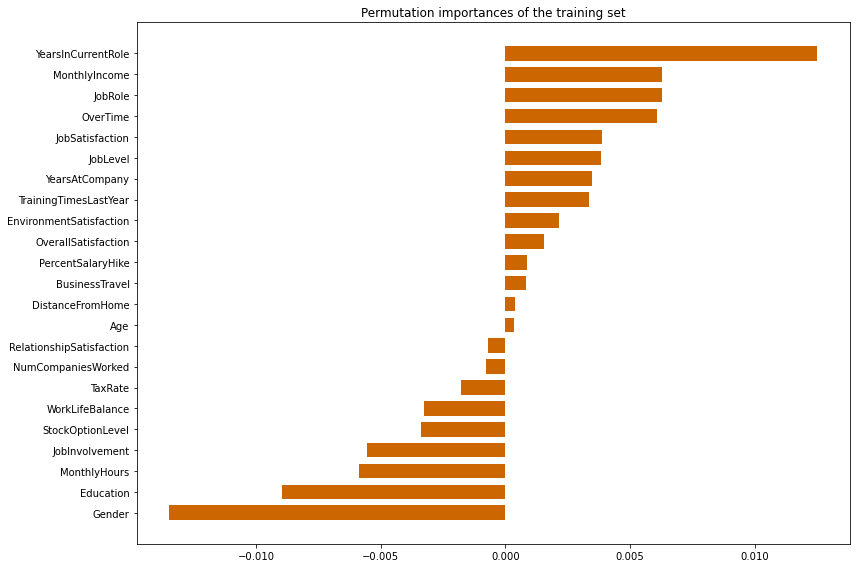



Predictions

Permutation importances of the test set

StockOptionLevel                                   0.045916
JobLevel                                           0.038955
OverallSatisfaction                                0.038368
WorkLifeBalance                                    0.028328
OverTime                                           0.021297
TrainingTimesLastYear                              0.018676
YearsInCurrentRole                                 0.017188
Gender                                             0.016984
EnvironmentSatisfaction                            0.015165
YearsAtCompany                                     0.013725
JobInvolvement                                     0.013663
MonthlyIncome                                      0.009523
MonthlyHours                                       0.006915
NumCompaniesWorked                                 0.003203
TaxRate                                            0.003016
JobRole                                     

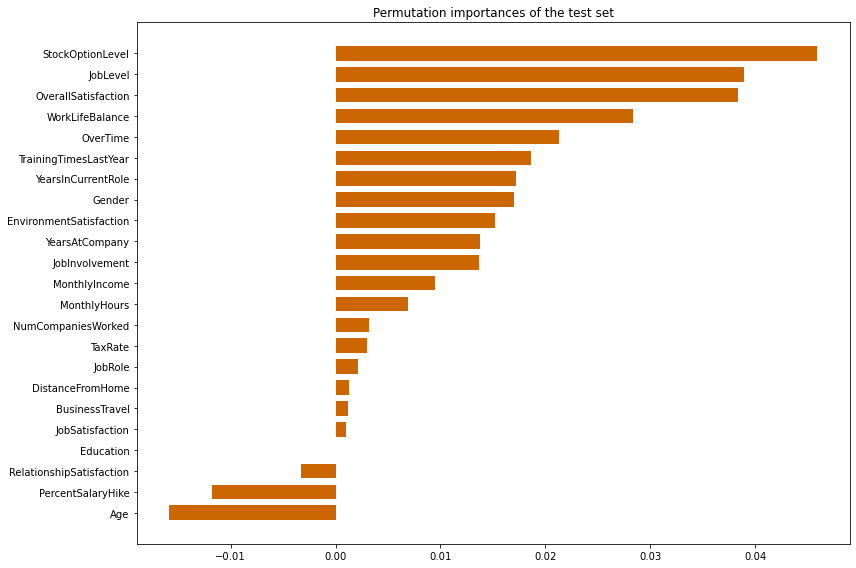



Confusion matrix


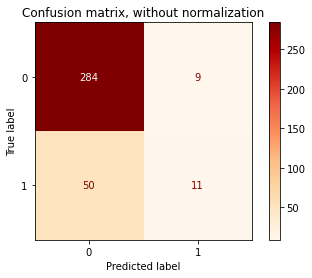

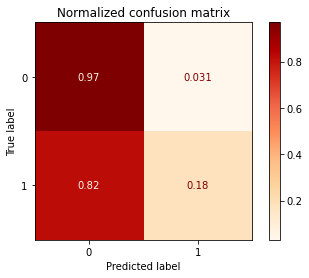


Classification report
              precision    recall  f1-score   support

           0       0.85      0.97      0.91       293
           1       0.55      0.18      0.27        61

    accuracy                           0.83       354
   macro avg       0.70      0.57      0.59       354
weighted avg       0.80      0.83      0.80       354


Metrics

Accuracy 0.8333333333333334
F1-score [0.90590112 0.27160494]
Precision [0.8502994 0.55     ]
Recall [0.96928328 0.18032787]
Roc_auc 0.5748055726514855


Roc curve



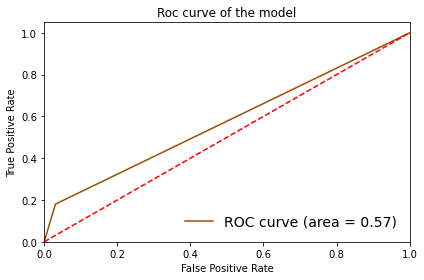


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.5839058591734526
Best parameters: {'n_neighbors': 2, 'p': 2, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


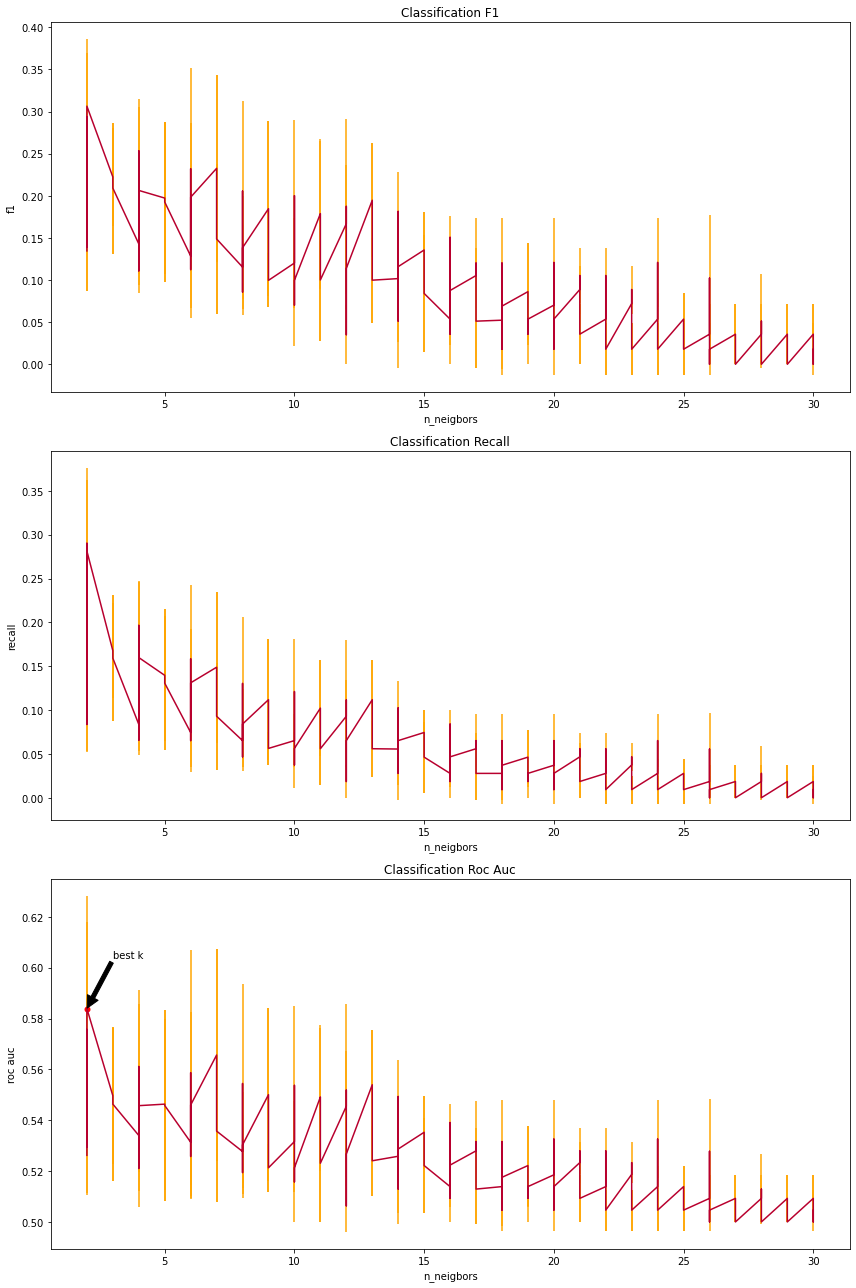



Permutation importances of the training set

TrainingTimesLastYear                              0.029519
NumCompaniesWorked                                 0.025656
JobRole                                            0.014064
YearsAtCompany                                     0.012418
JobLevel                                           0.010748
StockOptionLevel                                   0.010607
PercentSalaryHike                                  0.008412
MonthlyIncome                                      0.004650
WorkLifeBalance                                    0.002542
JobInvolvement                                     0.002054
OverallSatisfaction                                0.000533
YearsInCurrentRole                                 0.000016
BusinessTravel                                     0.000002
Age                                                0.000000
DistanceFromHome                                   0.000000
Education                                          0.

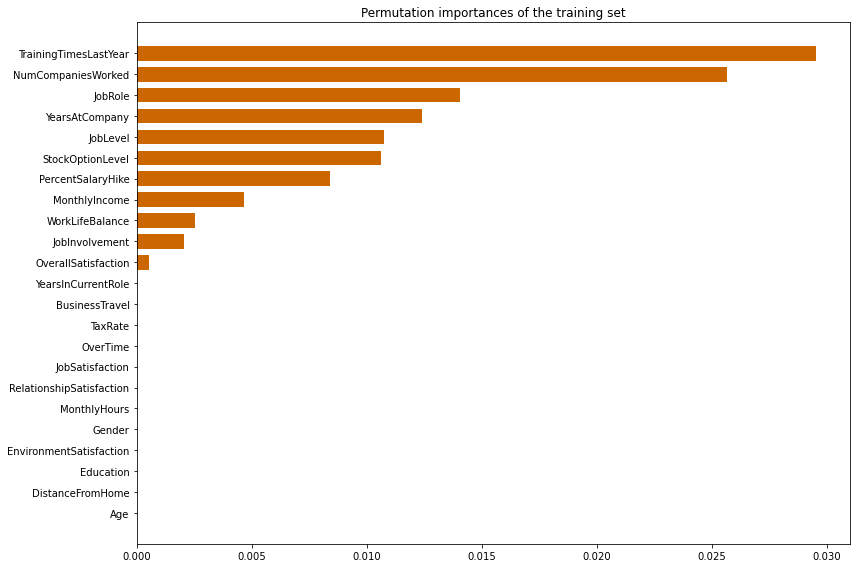



Predictions

Permutation importances of the test set

JobRole                                            0.047047
RelationshipSatisfaction                           0.037840
YearsAtCompany                                     0.036138
OverTime                                           0.035924
OverallSatisfaction                                0.034549
PercentSalaryHike                                  0.033165
JobLevel                                           0.032688
YearsInCurrentRole                                 0.022563
JobSatisfaction                                    0.021630
Education                                          0.020965
WorkLifeBalance                                    0.018012
NumCompaniesWorked                                 0.017094
EnvironmentSatisfaction                            0.016830
TrainingTimesLastYear                              0.016453
BusinessTravel                                     0.016026
MonthlyHours                                

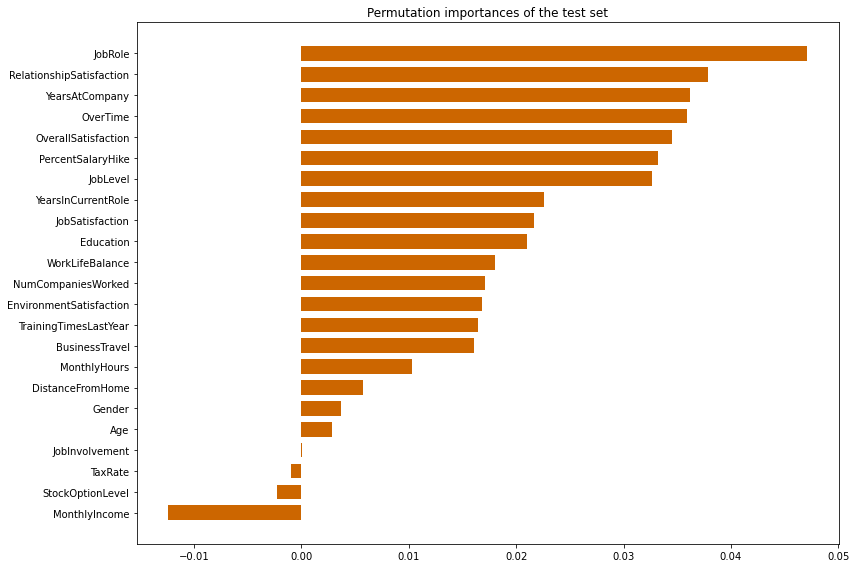



Confusion matrix


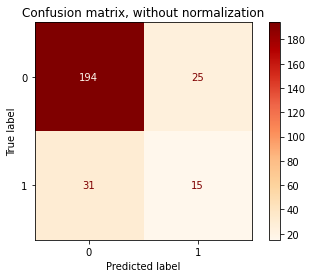

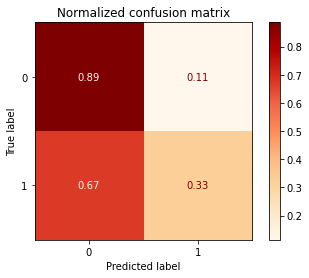


Classification report
              precision    recall  f1-score   support

           0       0.86      0.89      0.87       219
           1       0.38      0.33      0.35        46

    accuracy                           0.79       265
   macro avg       0.62      0.61      0.61       265
weighted avg       0.78      0.79      0.78       265


Metrics

Accuracy 0.7886792452830189
F1-score [0.87387387 0.34883721]
Precision [0.86222222 0.375     ]
Recall [0.88584475 0.32608696]
Roc_auc 0.6059658526900934


Roc curve



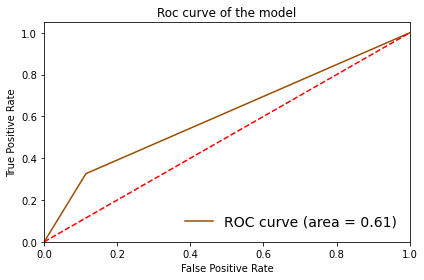


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.6025187803800265
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


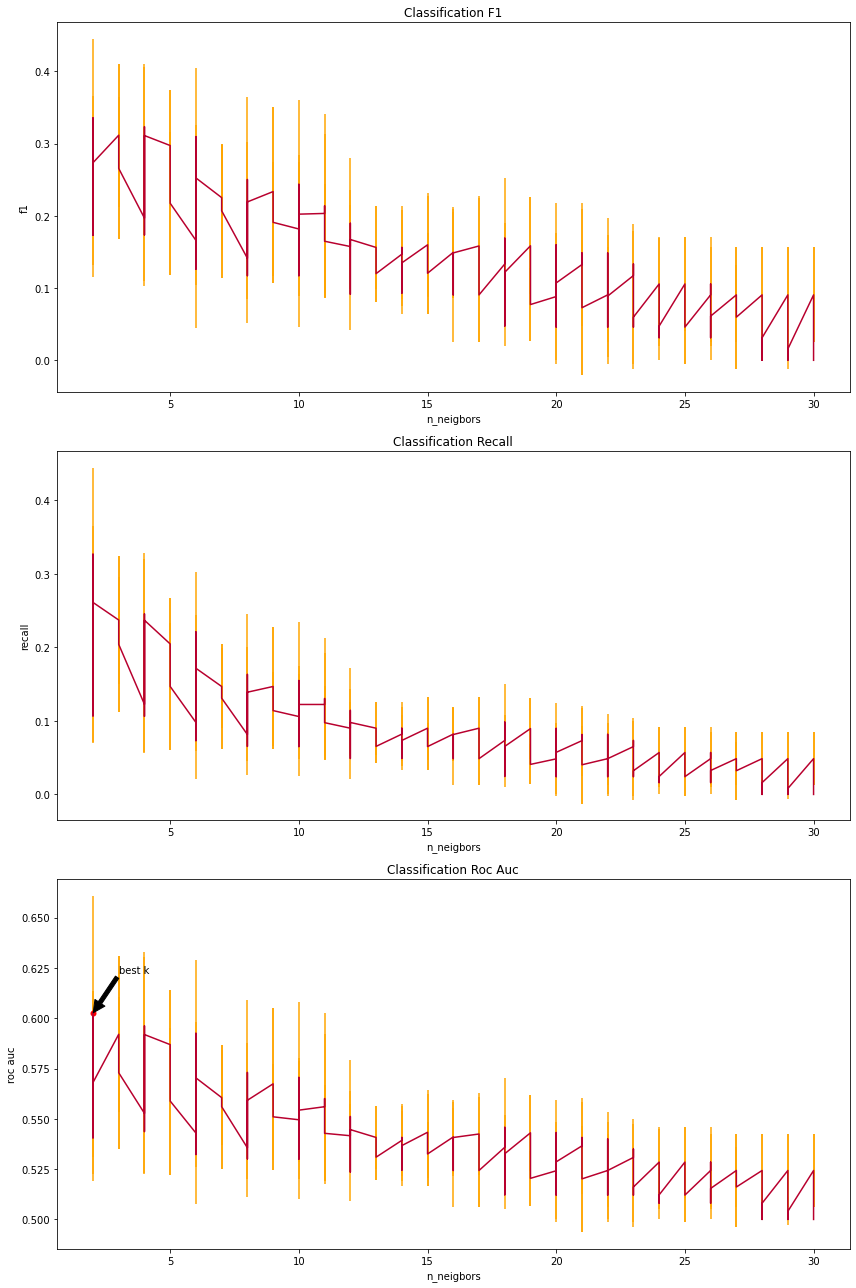



Permutation importances of the training set

Age                                                0.000000
BusinessTravel                                     0.000000
DistanceFromHome                                   0.000000
Education                                          0.000000
EnvironmentSatisfaction                            0.000000
Gender                                             0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole                                            0.000000
JobSatisfaction                                    0.000000
MonthlyHours                                       0.000000
MonthlyIncome                                      0.000000
NumCompaniesWorked                                 0.000000
OverTime                                           0.000000
OverallSatisfaction                                0.000000
PercentSalaryHike                                  0.

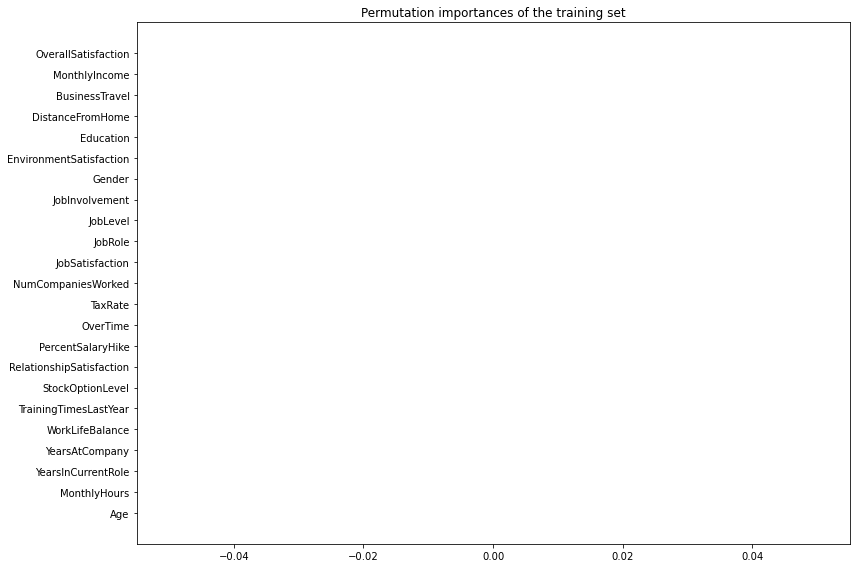



Predictions

Permutation importances of the test set

WorkLifeBalance                                    0.077408
YearsAtCompany                                     0.050519
YearsInCurrentRole                                 0.027209
BusinessTravel                                     0.025840
JobLevel                                           0.023321
DistanceFromHome                                   0.020636
StockOptionLevel                                   0.020051
OverallSatisfaction                                0.017455
RelationshipSatisfaction                           0.015411
PercentSalaryHike                                  0.008274
Age                                                0.006938
NumCompaniesWorked                                 0.006584
MonthlyHours                                       0.006463
EnvironmentSatisfaction                            0.004596
OverTime                                           0.004264
JobInvolvement                              

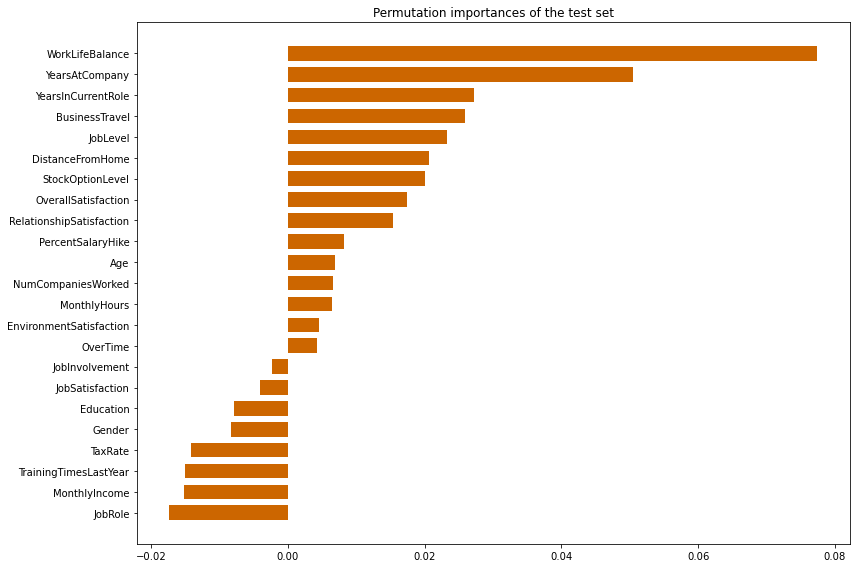



Confusion matrix


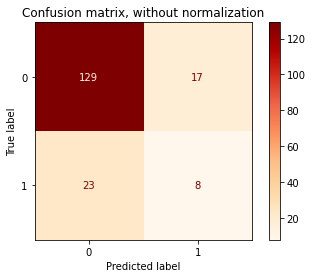

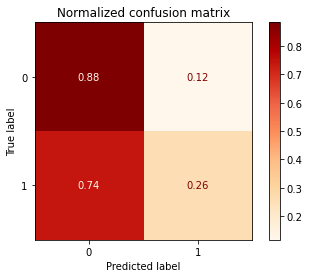


Classification report
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       146
           1       0.32      0.26      0.29        31

    accuracy                           0.77       177
   macro avg       0.58      0.57      0.58       177
weighted avg       0.76      0.77      0.76       177


Metrics

Accuracy 0.7740112994350282
F1-score [0.86577181 0.28571429]
Precision [0.84868421 0.32      ]
Recall [0.88356164 0.25806452]
Roc_auc 0.5708130799823243


Roc curve



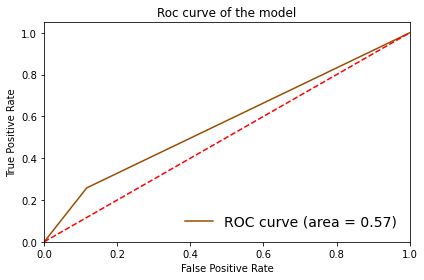


-------------------------------------------------------------------------------------------------------------



In [43]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
robust_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = RobustScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, robust_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = robust_dict

<h4>StandardScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.5801070638575625
Best parameters: {'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
Best estimator: KNeighborsClassifier(n_neighbors=7, p=1)

Best k ('n_neighbors'): 7

Plots of the metrics used by the grid search


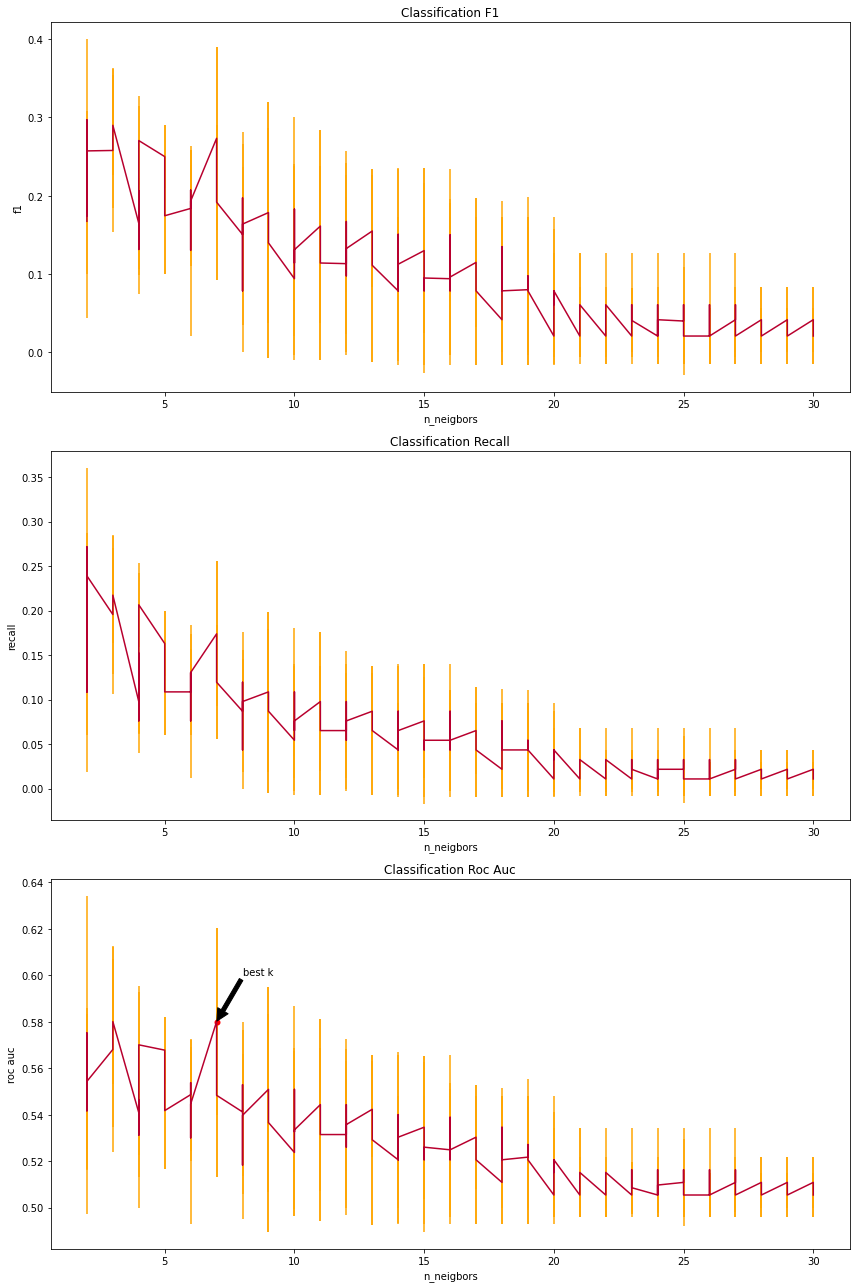



Permutation importances of the training set

OverTime                                           0.020865
MonthlyHours                                       0.009618
JobSatisfaction                                    0.008457
MonthlyIncome                                      0.004630
YearsInCurrentRole                                 0.004569
EnvironmentSatisfaction                            0.003444
JobRole                                            0.002236
YearsAtCompany                                     0.001265
OverallSatisfaction                                -0.000358
JobLevel                                           -0.000791
TaxRate                                            -0.001015
RelationshipSatisfaction                           -0.001347
BusinessTravel                                     -0.001986
NumCompaniesWorked                                 -0.003148
Age                                                -0.004059
DistanceFromHome                              

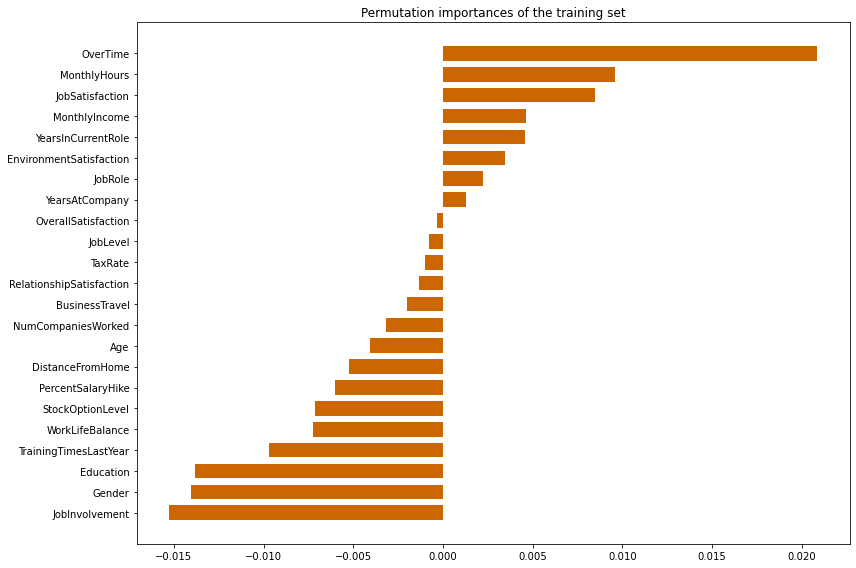



Predictions

Permutation importances of the test set

OverTime                                           0.047264
StockOptionLevel                                   0.034312
JobLevel                                           0.032776
OverallSatisfaction                                0.013274
YearsInCurrentRole                                 0.013014
MonthlyIncome                                      0.011593
JobInvolvement                                     0.011529
Age                                                0.009447
JobRole                                            0.008496
TrainingTimesLastYear                              0.007674
JobSatisfaction                                    0.006563
EnvironmentSatisfaction                            0.004722
TaxRate                                            0.002065
YearsAtCompany                                     0.001785
Gender                                             -0.000235
Education                                  

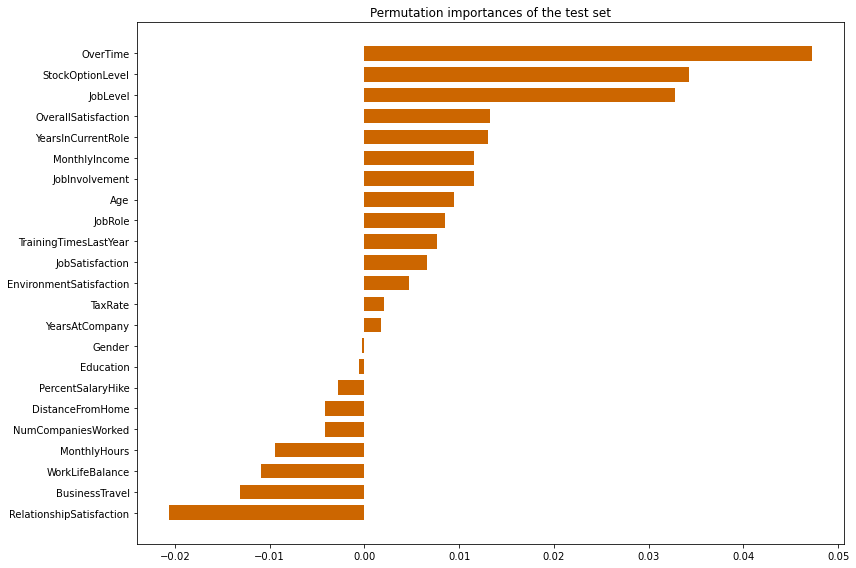



Confusion matrix


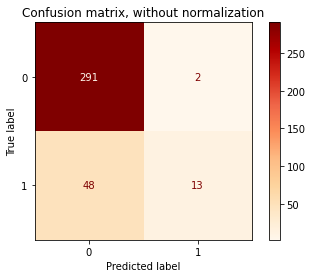

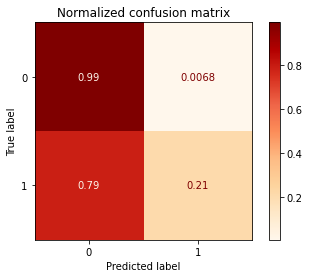


Classification report
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       293
           1       0.87      0.21      0.34        61

    accuracy                           0.86       354
   macro avg       0.86      0.60      0.63       354
weighted avg       0.86      0.86      0.82       354


Metrics

Accuracy 0.8587570621468926
F1-score [0.92088608 0.34210526]
Precision [0.85840708 0.86666667]
Recall [0.99317406 0.21311475]
Roc_auc 0.6031444077659038


Roc curve



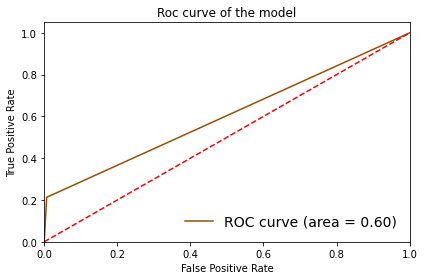


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.5800488349162685
Best parameters: {'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Best estimator: KNeighborsClassifier()

Best k ('n_neighbors'): 5

Plots of the metrics used by the grid search


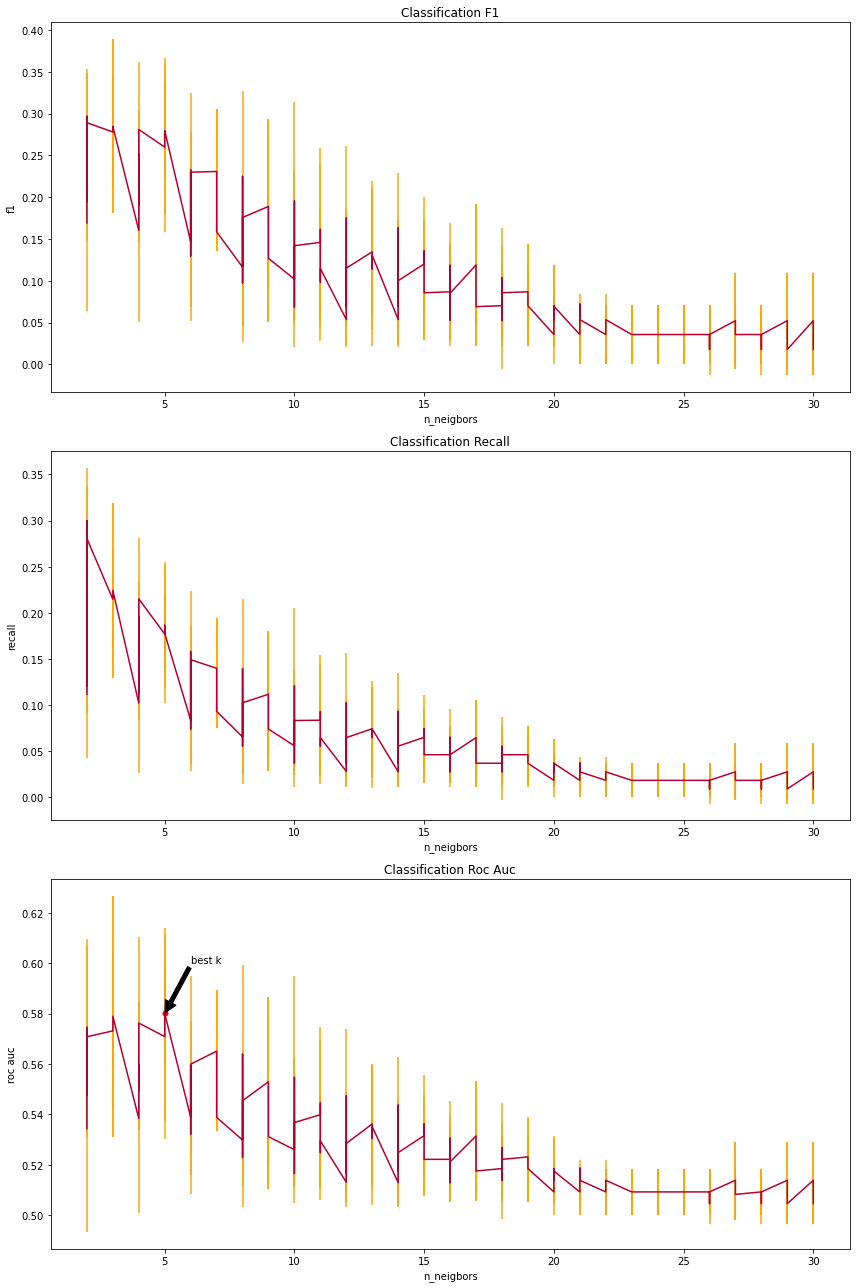



Permutation importances of the training set

JobRole                                            0.015280
RelationshipSatisfaction                           0.014496
JobLevel                                           0.012738
OverTime                                           0.012595
WorkLifeBalance                                    0.011359
StockOptionLevel                                   0.010222
EnvironmentSatisfaction                            0.006793
OverallSatisfaction                                0.006035
YearsInCurrentRole                                 0.005458
YearsAtCompany                                     0.005355
JobSatisfaction                                    0.005114
TrainingTimesLastYear                              0.002548
BusinessTravel                                     0.001533
PercentSalaryHike                                  0.001032
DistanceFromHome                                   0.000821
NumCompaniesWorked                                 -0

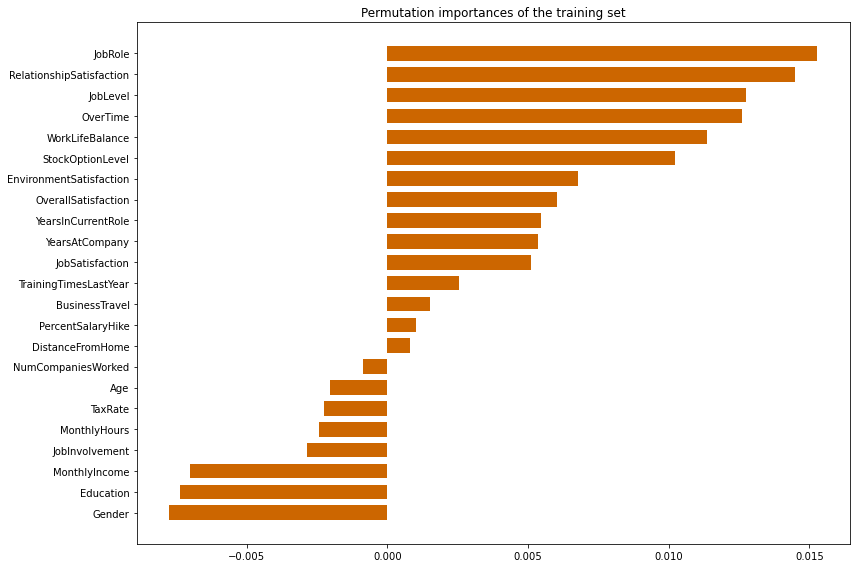



Predictions

Permutation importances of the test set

OverTime                                           0.065704
JobInvolvement                                     0.054189
NumCompaniesWorked                                 0.045697
StockOptionLevel                                   0.041339
Gender                                             0.038326
JobLevel                                           0.036664
JobRole                                            0.036311
YearsInCurrentRole                                 0.031254
YearsAtCompany                                     0.031120
JobSatisfaction                                    0.025501
OverallSatisfaction                                0.024613
PercentSalaryHike                                  0.023119
WorkLifeBalance                                    0.019044
Education                                          0.017764
BusinessTravel                                     0.013659
TrainingTimesLastYear                       

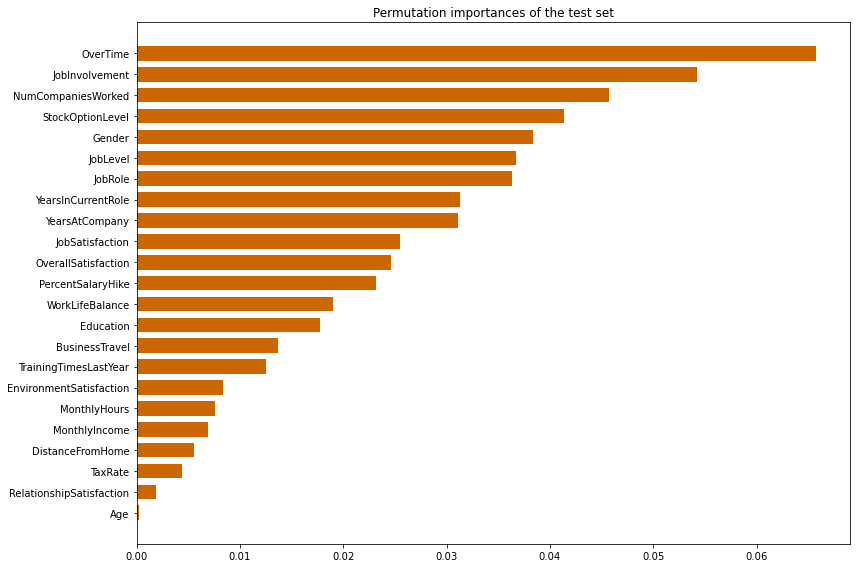



Confusion matrix


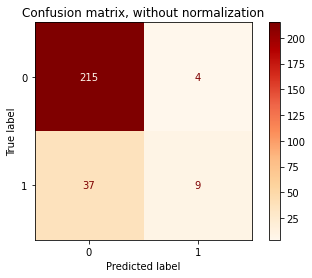

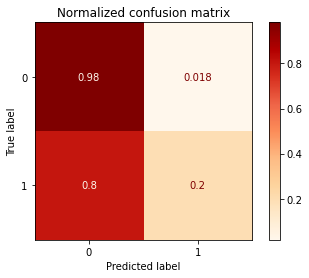


Classification report
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       219
           1       0.69      0.20      0.31        46

    accuracy                           0.85       265
   macro avg       0.77      0.59      0.61       265
weighted avg       0.83      0.85      0.81       265


Metrics

Accuracy 0.8452830188679246
F1-score [0.91295117 0.30508475]
Precision [0.8531746  0.69230769]
Recall [0.98173516 0.19565217]
Roc_auc 0.5886936668651975


Roc curve



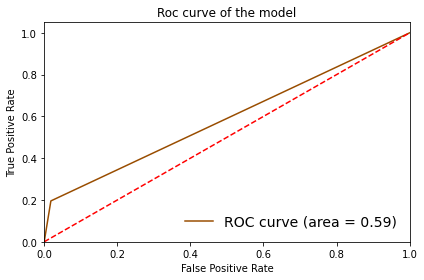


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.6052990131094418
Best parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best estimator: KNeighborsClassifier(n_neighbors=3, p=1)

Best k ('n_neighbors'): 3

Plots of the metrics used by the grid search


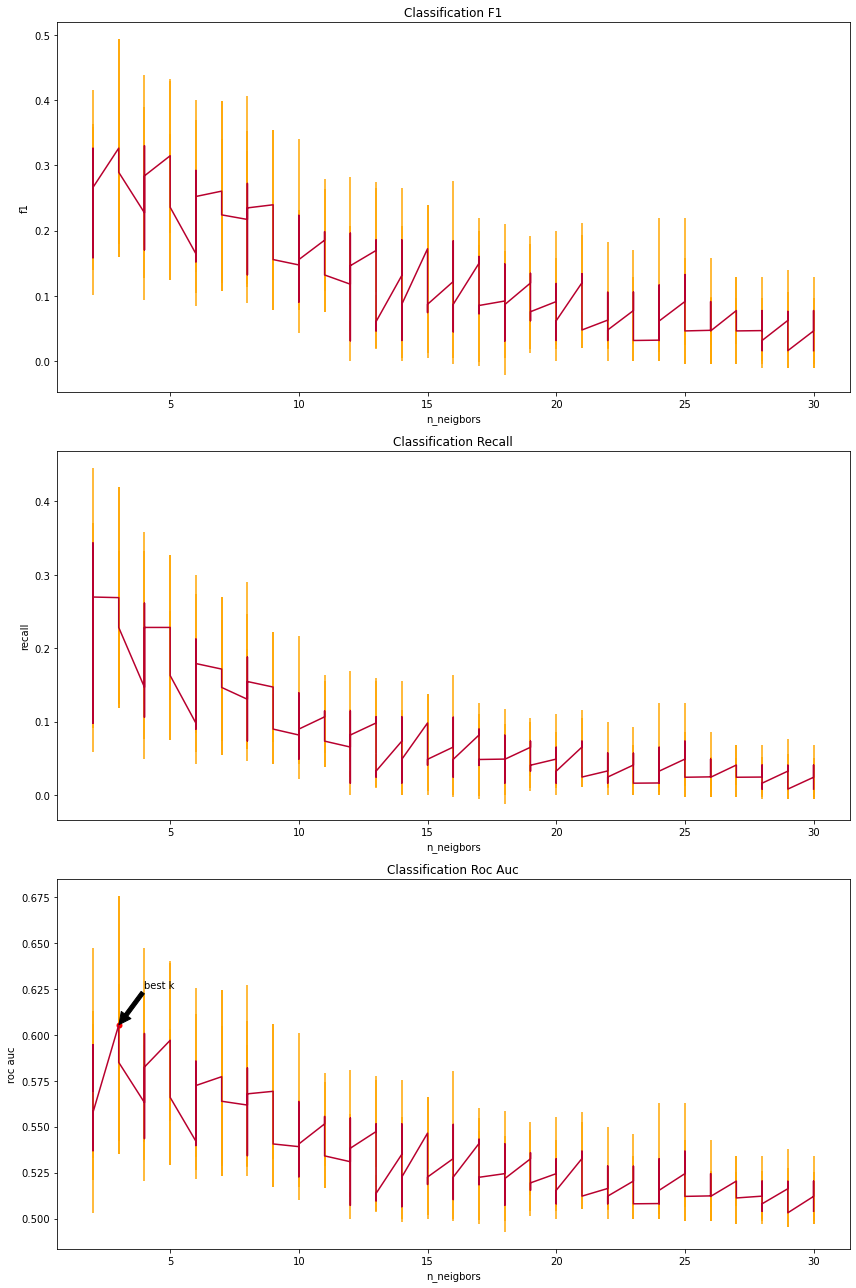



Permutation importances of the training set

OverTime                                           0.011381
StockOptionLevel                                   0.007200
YearsAtCompany                                     0.003072
EnvironmentSatisfaction                            0.002624
OverallSatisfaction                                0.002579
TaxRate                                            0.001566
JobInvolvement                                     0.000490
Age                                                -0.000496
NumCompaniesWorked                                 -0.000622
YearsInCurrentRole                                 -0.000839
WorkLifeBalance                                    -0.000909
JobRole                                            -0.000947
MonthlyIncome                                      -0.000960
RelationshipSatisfaction                           -0.001373
TrainingTimesLastYear                              -0.001429
JobLevel                                     

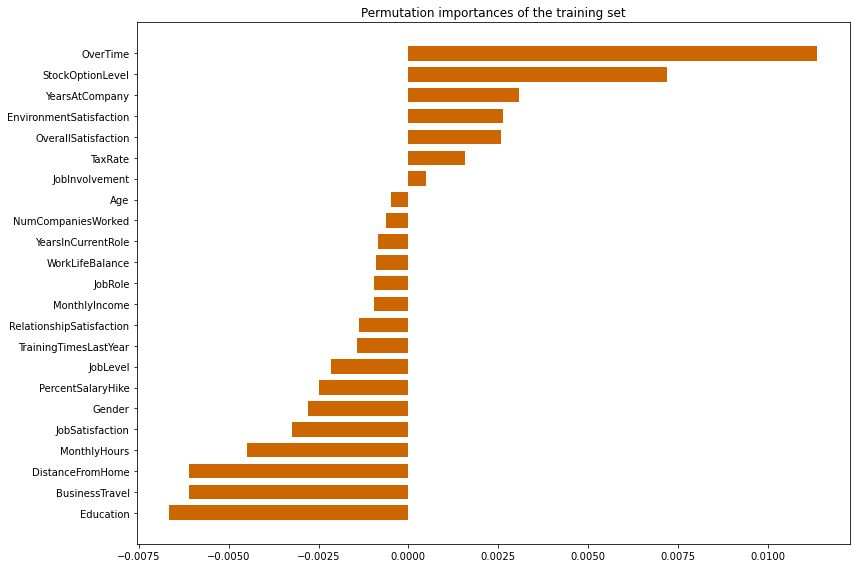



Predictions

Permutation importances of the test set

BusinessTravel                                     0.019929
MonthlyIncome                                      0.009456
YearsInCurrentRole                                 0.001016
OverTime                                           0.000320
NumCompaniesWorked                                 -0.000729
WorkLifeBalance                                    -0.003502
OverallSatisfaction                                -0.003524
DistanceFromHome                                   -0.008517
MonthlyHours                                       -0.012251
JobSatisfaction                                    -0.014328
Age                                                -0.019996
StockOptionLevel                                   -0.021553
JobLevel                                           -0.022757
JobRole                                            -0.024481
YearsAtCompany                                     -0.024680
PercentSalaryHike                

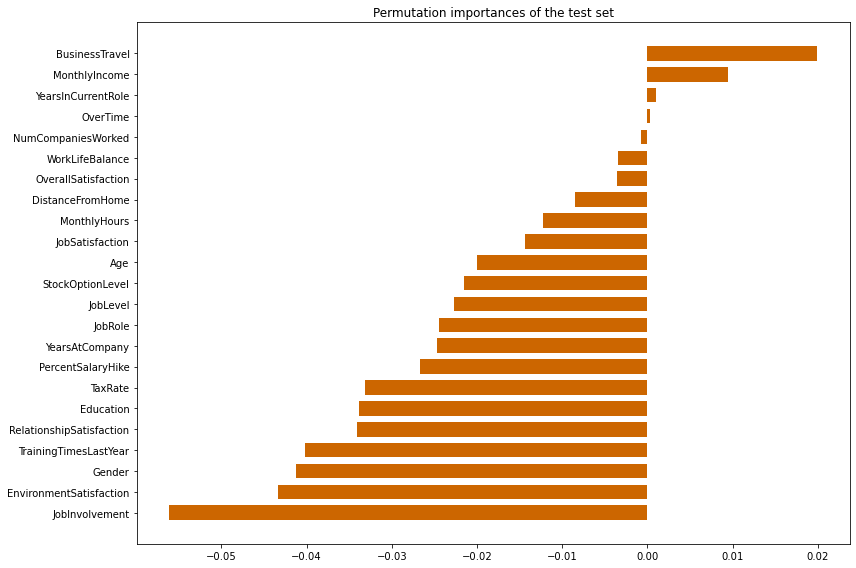



Confusion matrix


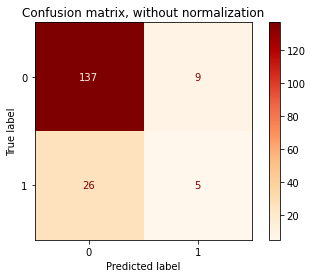

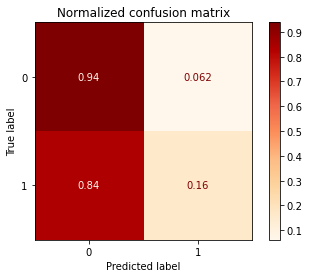


Classification report
              precision    recall  f1-score   support

           0       0.84      0.94      0.89       146
           1       0.36      0.16      0.22        31

    accuracy                           0.80       177
   macro avg       0.60      0.55      0.55       177
weighted avg       0.76      0.80      0.77       177


Metrics

Accuracy 0.8022598870056498
F1-score [0.88673139 0.22222222]
Precision [0.8404908  0.35714286]
Recall [0.93835616 0.16129032]
Roc_auc 0.5498232434821034


Roc curve



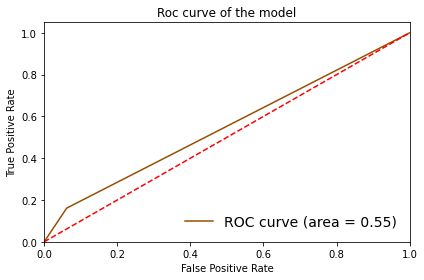


-------------------------------------------------------------------------------------------------------------



In [44]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
standard_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = StandardScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, standard_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = standard_dict

In [45]:
scaler_dict

{'MinMaxScaler': {'60-40': {'fpr': [0.0, 0.051194539249146756, 1.0],
   'tpr': [0.0, 0.16393442622950818, 1.0],
   'roc': 0.5563699434901808},
  '70-30': {'fpr': [0.0, 0.1324200913242009, 1.0],
   'tpr': [0.0, 0.3695652173913043, 1.0],
   'roc': 0.6185725630335518},
  '80-20': {'fpr': [0.0, 0.0410958904109589, 1.0],
   'tpr': [0.0, 0.16129032258064516, 1.0],
   'roc': 0.5600972160848432}},
 'MaxAbsScaler': {'60-40': {'fpr': [0.0, 0.023890784982935155, 1.0],
   'tpr': [0.0, 0.18032786885245902, 1.0],
   'roc': 0.5782185419347619},
  '70-30': {'fpr': [0.0, 0.1050228310502283, 1.0],
   'tpr': [0.0, 0.34782608695652173, 1.0],
   'roc': 0.6214016279531467},
  '80-20': {'fpr': [0.0, 0.0547945205479452, 1.0],
   'tpr': [0.0, 0.16129032258064516, 1.0],
   'roc': 0.55324790101635}},
 'RobustScaler': {'60-40': {'fpr': [0.0, 0.030716723549488054, 1.0],
   'tpr': [0.0, 0.18032786885245902, 1.0],
   'roc': 0.5748055726514855},
  '70-30': {'fpr': [0.0, 0.1141552511415525, 1.0],
   'tpr': [0.0, 0.326

In [50]:
temporal_info = {}

In [51]:
model_name = '24f numerical-encoded kmeans discretized'

In [52]:
temporal_info[model_name] = scaler_dict['MaxAbsScaler']['70-30']
temporal_info

{'24f numerical-encoded kmeans discretized': {'fpr': [0.0,
   0.1050228310502283,
   1.0],
  'tpr': [0.0, 0.34782608695652173, 1.0],
  'roc': 0.6214016279531467}}

In [53]:
with open('temporal_info.json', "r+") as json_file: 
    data = json.load(json_file)
    data['kmeans']['validation'].update(temporal_info)

    
with open('temporal_info.json','w') as f: 
    json.dump(data, f, indent=4)